In [1]:
import Revise

In [2]:
import QuantumCollocation as QC
import NamedTrajectories as NT
import TrajectoryIndexingUtils as NTidx
import LinearAlgebra as LA
import SparseArrays as SA
import ForwardDiff as FD
import Plots
import Interpolations as IP
using LaTeXStrings
import JLD2

using FFTW:ifft, fft, fftshift, fftfreq

In [4]:
repo_path = "/local/lmseifert/Other/shaken_lattice_qoc/"
src_path = repo_path * "src/"
include(src_path * "utils.jl")
include(src_path * "system.jl")
include(src_path * "constraints.jl")
include(src_path * "objectives.jl")

QuadraticObjective (generic function with 3 methods)

In [5]:
V = 10.
trunc = 13
# E_R [kHz] found in Weidner thesis
system = ShakenLatticeSystem1D(V, trunc; bloch_basis=true, bloch_transformation_trunc=3*trunc)
# middle index of statevector where p = 0
mid = system.params[:mid]
dim = system.params[:dim]
E_R = system.params[:E_R]
#E_R = 1/0.05
#print("time unit $(1/E_R) ms\nE_R = $E_R kHz")

8.939026187912745

In [6]:
system.params[:bloch_energies]

39-element Vector{Float64}:
   -2.153078342041735
    3.4924743667389517
    5.613041084867151
   16.194837346915975
   16.227316187360763
   36.089436879709716
   36.08946965587397
   64.04962982471427
   64.04962983201821
  100.03157230514728
  100.03157230514785
  144.02185531525708
  144.0218553152571
    ⋮
  784.0039910728271
  784.0039910728271
  900.0034760929894
  900.0034760929907
 1024.0030547466874
 1024.0030547466897
 1156.0027056320225
 1156.002705632023
 1296.002418994283
 1296.002418994286
 1444.0422238741496
 1444.04222387415

In [7]:
system.H_drives_real[1]

13×13 Matrix{Float64}:
 -3.31353       4.85523e-15  -1.95634      …  -9.2715e-8    -9.27631e-8
  4.55157e-15  -0.989958     -1.13397e-14     -4.323e-7      4.32076e-7
 -1.95634      -1.14221e-14   2.19635         -5.43921e-7   -5.44203e-7
  7.11761e-13   2.38146       2.58165e-12      8.34514e-6   -8.34081e-6
 -0.699748      2.47477e-12  -2.52663         -8.34328e-6   -8.3476e-6
 -6.89663e-11  -0.192284     -3.40529e-10  …  -0.000336855   0.00033668
 -0.0465362     2.84963e-10  -0.229777        -0.00033668   -0.000336855
 -8.47438e-9   -0.00533246   -4.6346e-8       -0.0223329     0.022321
 -0.0012026     3.75762e-8   -0.00657698      -0.022321     -0.0223329
 -1.56006e-6    7.35211e-5   -8.93116e-6       1.58885      -1.92987
 -1.60538e-5   -7.14454e-6   -9.19063e-5   …  -1.92987      -1.58885
 -9.2715e-8    -4.323e-7     -5.43921e-7       0.043715      1.06958e-16
 -9.27631e-8    4.32076e-7   -5.44203e-7       1.06953e-16   0.043715

df = DF.DataFrame(CSV.File("./paper_data/split_fig6_coarse.csv"; header=0))

times = df[:,1] * E_R
dts = times[2:end] - times[1:end-1]
#push!(dts, dts[end])
#push!(dts, 0.)
phi = df[1:end-1,2]
#push!(phi, 0.)

duration = sum(dts) # in 1/E_R

T = length(dts)
dt_avg = duration / (T-1)
#dts = zeros(T) .+ dt
dt_bound = (minimum(dts), maximum(dts))
times = cumsum(dts) - dts

a_bound = fill(1., 2)
dda_bound = fill(50., 2)

a = vcat(cos.(phi)', sin.(phi)')

da = NT.derivative(a, dts)
dda = NT.derivative(da, dts)

In [8]:
duration = 2pi * 0.25 # in units of 1/E_R

T = 251
dt = duration / (T-1)
dts = zeros(T) .+ dt
dt_bound = (dt, dt)
times = cumsum(dts) - dts
duration

1.5707963267948966

In [14]:
#phi = collect(sin.(11.5 *times)')
phi = rand(1, T)
A = ones(1, T)
# d = A .* exp.(1im*phi)
a = rphi_to_IQ(A, phi)

# dA = NT.derivative(A, dts)
# ddA = NT.derivative(dA, dts)

2×251 Matrix{Float64}:
 0.825938  0.96444   0.999726   0.967619  …  0.990899  0.999257   0.776575
 0.563762  0.264304  0.0233913  0.252414     0.134607  0.0385445  0.630024

In [29]:
Z = NT.load_traj(repo_path * "interferometer/mirror_victor2_opt2.jld2")

NamedTrajectories.StructNamedTrajectory.NamedTrajectory{Float64}([0.0 7.566076388956792e-19 … -0.003664013594259433 -0.0008925177526316505; 0.0 -5.726095340855611e-18 … 0.00012379046962068946 -7.226128856801889e-5; … ; -1248.478871255009 -956.8208959040003 … 1152.9162225993948 1152.9162225993948; 0.010927299999999997 0.010927299999999997 … 0.01092729999999964 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  -2.897632453648897e-6, 2.6111246514126513e-5, -0.0020331013753904746, 1.0922345902444226, -0.07843634054638379, 15.351690028056614, 25.840900592617476, 876.9732720034417, 1152.9162225993948, 0.0], 350, :dts, 29, (psi_iso = 22, a = 2, da = 2, dda = 2, dts = 1, states = 27, controls = 2), (a = ([-1.0, -1.0], [1.0, 1.0]), dda = ([-2000.0, -2000.0], [2000.0, 2000.0]), dts = ([0.01092730000000002], [0.01092730000000002])), (psi_iso = [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], a = [1.0, 0.0]), (a = [1.0, 0.0],), Name

In [35]:
Z.T

350

In [33]:
sum(Z.dts) / 2/pi

0.6069576995671768

NT.plot(Z, (:a, :phi), transformations=Dict(:psi_iso => x -> abs2.(QC.iso_to_ket(x))))

In [11]:
a, phi, dts = Z.a, Z.phi, vec(Z.dts)
# dts_new = fill(0.3*2pi/300, 301)
# a = interpolate_controls(a, dts, dts_new)
# dts = dts_new

# phi = collect(atan.(a[2,:], a[1,:])')
# phi_mod_clean!(phi)

slice = 1:length(dts)
a = a[:,slice]
dts = dts[slice]
phi = phi[:,slice]

times = cumsum(dts) - dts
T = length(times)

LoadError: UndefVarError: `Z` not defined

In [15]:
duration = times[end]
T = length(times)
dt = duration/(T-1)
dt_bound = (dt, dt)
T

251

In [16]:
phi_bound = [1.0*pi]
# ddA_bound = [1000.]

# dA = NT.derivative(A, dts)
# ddA = NT.derivative(dA, dts)

1-element Vector{Float64}:
 3.141592653589793

In [17]:
duration/2pi

0.2500000000000007

In [18]:
times

251-element Vector{Float64}:
 0.0
 0.006283185307179587
 0.012566370614359171
 0.01884955592153876
 0.025132741228718346
 0.031415926535897934
 0.03769911184307752
 0.0439822971502571
 0.050265482457436686
 0.05654866776461627
 0.06283185307179585
 0.06911503837897544
 0.07539822368615502
 ⋮
 1.5016812884159252
 1.5079644737231048
 1.5142476590302845
 1.520530844337464
 1.5268140296446437
 1.5330972149518234
 1.539380400259003
 1.5456635855661827
 1.5519467708733623
 1.558229956180542
 1.5645131414877216
 1.5707963267949012

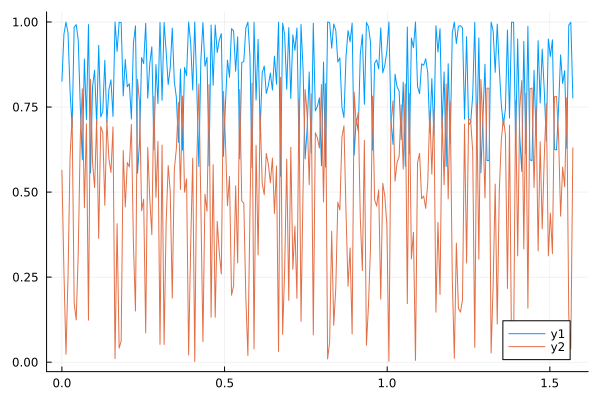

In [19]:
Plots.plot(times, a')

In [20]:
Plots.plot(times, phi')

psi0 = zeros(system.params[:dim])
psi0[mid] = 0.
psi0[mid-1] = sqrt(0.5)
psi0[mid+1] = sqrt(0.5)
normalize!(psi0)

In [21]:
#psi0 = get_bloch_state(system; lvl=0)
psi0 = QC.cavity_state(0, dim)

13-element Vector{ComplexF64}:
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

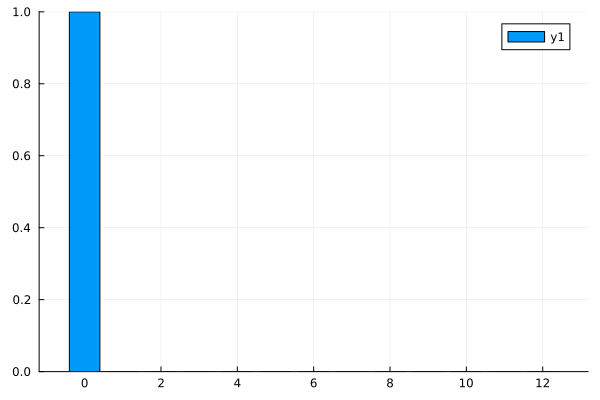

In [22]:
#Plots.bar(-p_max:p_max, abs2.(psi0))
Plots.bar(0:dim-1, abs2.(psi0))

In [23]:
psi0_iso = QC.ket_to_iso(psi0)

26-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [24]:
psi_iso = QC.rollout(psi0_iso, a, dts, system; integrator=exp)

26×251 Matrix{Float64}:
 1.0   0.999888      0.999608      0.999202     …  -0.851943     -0.852215
 0.0  -0.0107425    -0.0157746    -0.0162106        0.158729      0.149933
 0.0  -7.45082e-7   -4.72262e-5   -0.00013484       0.203418      0.207749
 0.0   0.0025003     0.00364536    0.00368475       0.0298359     0.0313397
 0.0   6.07767e-6   -2.75701e-5   -0.00011578       0.0365516     0.0366886
 0.0  -0.000162715  -0.000228372  -0.000212049  …   0.00100692    0.00132931
 0.0   7.789e-6      1.10147e-5   -2.2694e-6        9.91109e-5   -0.000353553
 0.0  -4.04345e-6   -4.94765e-6   -3.16802e-6      -8.99555e-5   -7.32667e-5
 0.0   8.27167e-7    1.3745e-6     4.17183e-7       0.000145222   0.000173511
 0.0   5.17772e-8    4.07761e-8   -2.23795e-8      -9.37786e-7   -3.03511e-6
 0.0   2.36891e-8    3.48193e-8   -6.87677e-9   …  -4.36593e-6   -3.27584e-6
 0.0   7.38157e-11   2.45275e-10   6.04894e-11      5.43325e-9   -1.45861e-8
 0.0   5.46891e-10   2.51441e-11  -1.42683e-9      -1.3102

In [97]:
psi_iso += rand(size(psi_iso)...)

26×251 Matrix{Float64}:
 1.78932    1.24431    1.71296    …  -0.167031  -0.59575    -0.241456
 0.674506   0.0307116  0.298027       0.931168   0.987266    0.54498
 0.826552   0.830873   0.456652       0.998866   0.997033    0.399749
 0.895179   0.271946   0.957408       0.869931   0.494551    0.46266
 0.138993   0.042897   0.648713       0.632377   0.16304     0.364423
 0.561074   0.193417   0.369335   …   0.860088   0.419794    0.754849
 0.115653   0.942889   0.0468176      0.581648   0.194002    0.427775
 0.327938   0.360495   0.500114       0.136463   0.36297     0.986749
 0.290266   0.900771   0.131386       0.384425   0.547359    0.657884
 0.699109   0.637002   0.0395177      0.162995   0.346172    0.879912
 0.391804   0.295542   0.725687   …   0.840978   0.725793    0.411637
 0.360427   0.919499   0.0464598      0.654466   0.822909    0.726213
 0.668298   0.770836   0.279113       0.807654   0.332859    0.223854
 0.176885   0.0892223  0.29666        0.94731    0.560536    0.34827

In [25]:
psi = hcat([QC.iso_to_ket(psi_iso[:,t]) for t=1:T]...)
pops = abs2.(psi)

13×251 Matrix{Float64}:
 1.0  0.999873     0.99973      0.999715     …  0.726972     0.726767
 0.0  0.000115406  0.000248908  0.000263147     0.212526     0.212721
 0.0  4.5763e-6    6.6313e-6    6.64743e-6      0.057982     0.057995
 0.0  6.27049e-6   1.34893e-5   1.42485e-5      0.0011607    0.00116217
 0.0  5.86152e-7   8.49355e-7   8.50991e-7      0.00135138   0.00134624
 0.0  2.71792e-8   5.80013e-8   6.10591e-8   …  3.77123e-6   3.68839e-6
 0.0  2.75476e-9   4.4217e-9    4.48018e-9      4.28229e-6   4.16136e-6
 0.0  1.87985e-11  4.01246e-11  4.19242e-11     8.75483e-9   8.97289e-9
 0.0  3.01933e-12  8.10454e-12  8.62751e-12     3.1605e-8    3.15103e-8
 0.0  4.67653e-15  1.1275e-14   1.17484e-14     1.73971e-11  1.67968e-11
 0.0  1.2906e-15   5.34819e-15  5.82856e-15  …  1.92216e-11  1.8831e-11
 0.0  1.11866e-20  7.5034e-20   8.46199e-20     5.12985e-16  6.33614e-16
 0.0  9.77436e-19  3.4118e-18   3.61657e-18     3.88401e-14  3.82901e-14

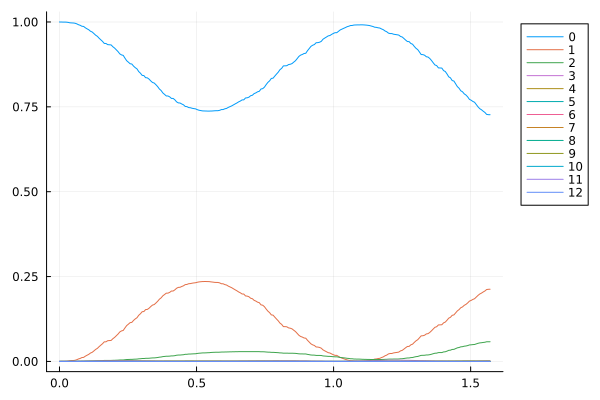

In [26]:
#Plots.plot(times, pops[:,:]', labels=(-p_max:1:p_max)', legend=:outertopright)#, xlim=(0.0, 2.0))
Plots.plot(times, pops[:,:]', labels=(0:dim-1)', legend=:outertopright)#, xlim=(0.0, 2.0))

bloch_states = hcat([get_bloch_state(system; lvl=i) for i=0:dim-1]...)

psi

blochs = bloch_states' * psi
bloch_pops = abs2.(blochs)

Plots.plot(times, bloch_pops[:,:]', labels=(0:8)', legend=:outertopright)#, xlim=(0.0, 2.0))

pops[:, end]

In [27]:
comps = (
    psi_iso = psi_iso,
    a = a,
    # A = A,
    phi = phi,
    # dA = dA,
    # ddA = ddA,
    dts = dts
)
initial = (
    psi_iso = psi0_iso,
    # A = [1.],
    phi = [0.],
    #dphi = [0.]
)
final = (;
    # A = [1.],
    phi = [0.],
    #dphi = [0.]
)
goal = (;)
bounds = (
    phi = phi_bound,
    # ddA = ddA_bound,
    dts = dt_bound
)

Z_guess = nothing
GC.gc()
Z_guess = NT.NamedTrajectory(
    comps;
    controls=(:phi),
    timestep=:dts,
    bounds=bounds,
    initial=initial,
    final=final,
    goal=goal
)

NamedTrajectories.StructNamedTrajectory.NamedTrajectory{Float64}([1.0 0.9998875118510729 … -0.8519427556078488 -0.8522148153413956; 0.0 -0.010742541110920323 … 0.1587288543301717 0.1499328983361719; … ; 0.5989330946856571 0.26748185683764925 … 0.03855403167308369 0.6815847589697461; 0.006283185307179587 0.006283185307179587 … 0.006283185307179587 0.006283185307179587], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  6.00407141694455e-5, 3.747210449519533e-5, -2.7540686086400144e-6, 2.8460198416608736e-6, -2.0514868556662575e-8, 1.3137953176847776e-7, 0.776575257361535, 0.6300244992489306, 0.6815847589697461, 0.006283185307179587], 251, :dts, 30, (psi_iso = 26, a = 2, phi = 1, dts = 1, states = 29, controls = 1), (phi = ([-3.141592653589793], [3.141592653589793]), dts = ([0.006283185307179605], [0.006283185307179605])), (psi_iso = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], phi = [0.0]), (phi = [0.0],), NamedTuple(), (ps

In [28]:
Z_guess.bounds

(phi = ([-3.141592653589793], [3.141592653589793]), dts = ([0.006283185307179605], [0.006283185307179605]))

import JLD2

JLD2.save("./interferometer/mirror_victor2.jld2", Z_guess)

Z_guess = NT.copy(Z_save)

NT.update_bounds!(Z_guess, :dda, [-5000. -5000.; 5000. 5000.])

In [101]:
dim = system.params[:dim]

13

In [102]:
R = 1.0 * collect(LA.I(dim))
R[10,10] = R[11,11] = 0.
R = QC.QuantumSystems.iso(R)
# R[8,8] = R[9+dim,9+dim] = 0. # this should get populations right AND fix y-z greatcircle
R

26×26 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [103]:
kernel = sinc_kernel(50., vec(Z_guess.dts))
convolver = LA.I(Z_guess.T) - kernel
convolver = convolver' * convolver

251×251 Matrix{Float64}:
  0.854797     -0.137901     -0.126295     …   0.00162014    0.00227669
 -0.137901      0.864473     -0.128699         0.000877085   0.00162014
 -0.126295     -0.128699      0.873224         7.93683e-5    0.000838229
 -0.111092     -0.117851     -0.120669        -0.000697896   5.16046e-6
 -0.0931985    -0.103648     -0.110772        -0.00138203   -0.000800448
 -0.0736509    -0.0869365    -0.0976927    …  -0.00190975   -0.00150308
 -0.0535463    -0.068688     -0.082217        -0.00223318   -0.00203755
 -0.0339668    -0.0499277    -0.065247        -0.0023244    -0.00235522
 -0.0159075    -0.0316664    -0.0477403       -0.00217803   -0.00242864
 -0.000213182  -0.0148325    -0.0306442       -0.00181171   -0.00225408
  0.0124726    -0.000213182  -0.0148326    …  -0.00126424   -0.00185186
  0.0217419     0.011593     -0.00104971      -0.000591763  -0.00126424
  0.0274388     0.0202083     0.0101346        0.000137767  -0.000551281
  ⋮                                 

In [104]:
Z_guess.psi_iso

26×251 Matrix{Float64}:
 1.78932    1.24431    1.71296    …  -0.167031  -0.59575    -0.241456
 0.674506   0.0307116  0.298027       0.931168   0.987266    0.54498
 0.826552   0.830873   0.456652       0.998866   0.997033    0.399749
 0.895179   0.271946   0.957408       0.869931   0.494551    0.46266
 0.138993   0.042897   0.648713       0.632377   0.16304     0.364423
 0.561074   0.193417   0.369335   …   0.860088   0.419794    0.754849
 0.115653   0.942889   0.0468176      0.581648   0.194002    0.427775
 0.327938   0.360495   0.500114       0.136463   0.36297     0.986749
 0.290266   0.900771   0.131386       0.384425   0.547359    0.657884
 0.699109   0.637002   0.0395177      0.162995   0.346172    0.879912
 0.391804   0.295542   0.725687   …   0.840978   0.725793    0.411637
 0.360427   0.919499   0.0464598      0.654466   0.822909    0.726213
 0.668298   0.770836   0.279113       0.807654   0.332859    0.223854
 0.176885   0.0892223  0.29666        0.94731    0.560536    0.34827

In [105]:
state_goal = QC.cavity_state(3, dim)

13-element Vector{ComplexF64}:
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

In [106]:
#J = NameComponentObjective(:psi_iso, [1:dim...], [1:T...], x -> 1 - abs2.(x' * state_goal), ([1:T...] ./ T) .* 100.; is_iso=true)
J1 = QC.QuantumObjective(name=:psi_iso, goals=QC.ket_to_iso(state_goal), loss=:InfidelityLoss, Q=100.0)
#J += QC.QuadraticRegularizer(:dts, Z_guess, 0.01)
#J += NameComponentQuadraticRegularizer(:a, [2], Z_guess, [0.001])

#J1 = QuadraticObjective(:psi_iso, Z_guess, R; Q=200.0)
# J2 = NameComponentObjective(:psi_iso, [8, 9], [T], x -> real(x[1]'*x[2])^2, [100.0]; is_iso=true)
# J4 = QC.QuadraticRegularizer(:ddphi, Z_guess, 1e-8/T)
# J5 = QC.QuadraticRegularizer(:dts, Z_guess, 1e1/T)
#J5 = NameComponentQuadraticRegularizer(:psi_iso, [13], Z_guess, [1e1/T]; is_iso=true)

# convolution
J4 = QuadraticObjective(:phi, Z_guess, convolver, [1], 1:Z_guess.T; Q=50.0/T)

J = J1 + J4

QuantumCollocation.Objectives.Objective(QuantumCollocation.Objectives.var"#1#7"{QuantumCollocation.Objectives.Objective, QuantumCollocation.Objectives.Objective}(QuantumCollocation.Objectives.Objective(QuantumCollocation.Objectives.var"#L#21"{Vector{QuantumCollocation.Losses.InfidelityLoss}}(Core.Box((:psi_iso,)), Core.Box(:InfidelityLoss), Core.Box([100.0]), QuantumCollocation.Losses.InfidelityLoss[QuantumCollocation.Losses.InfidelityLoss(QuantumCollocation.Losses.var"#22#25"{Vector{Float64}}([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), QuantumCollocation.Losses.var"#23#26"{QuantumCollocation.Losses.var"#22#25"{Vector{Float64}}}(QuantumCollocation.Losses.var"#22#25"{Vector{Float64}}([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])), QuantumCollocation.Losses.var"#61#62"(), [(4, 4), (4, 17), (17, 17)], :psi_iso)]), QuantumCollocation.Objectives.var"#∇L#22"{Vector{Quantum

In [107]:
J.L(Z_guess.datavec, Z_guess)

13.446629933127218

In [108]:
integrators = nothing
GC.gc()
integrators = [
    QC.QuantumStatePadeIntegrator(
        system,
        :psi_iso,
        :a,
        :dts;
        order=4
    ),
    # QC.DerivativeIntegrator(
    #     :A,
    #     :dA,
    #     :dts,
    #     Z_guess
    # ),
    # QC.DerivativeIntegrator(
    #     :dA,
    #     :ddA,
    #     :dts,
    #     Z_guess
    # )
]

1-element Vector{QuantumCollocation.Integrators.QuantumStatePadeIntegrator{Float64}}:
 QuantumCollocation.Integrators.QuantumStatePadeIntegrator{Float64}(nothing, nothing, [1.160447754875659 -5.594466076454682e-15 … 9.271503567350553e-8 9.276310935102601e-8; -5.594405513746107e-15 4.482431989861644 … 4.322997308939823e-7 -4.3207569530499453e-7; … ; 9.27150356735067e-8 4.322997308939808e-7 … 143.97814034661678 -1.3007917600274675e-16; 9.27631093510274e-8 -4.3207569530500125e-7 … -1.3289979571955581e-16 143.97814034661675], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [[-3.313526096917395 4.855230060710805e-15 … -9.271503567352554e-8 -9.276310935107244e-8; 4.551570362061718e-15 -0.989957623122687 … -4.322997308940166e-7 4.320756953051173e-7; … ; -9.271503567352657e-8 -4.3229973089401554e-7 … 0.04371496864049468 1.0695767002499315e-16; -9.27631093510709e-8 4.320756953051205e-7 … 1.0695293321248293e-16 0.04371496864049443], [0.0 0.0 … 0.0 0.0; 0.0 0.0 …

In [109]:
constraints = [
    #QC.ComplexModulusContraint(:a, 1.0, Z_guess)
    IQPhiConstraint(:a, :phi, Z_guess),
    #FinalYZGreatCircleConstraint(:psi_iso, [10, 11], Z_guess)
    #LinearSincConvolutionConstraint(:phi, :dts, Z_guess, 60.)
    #OmegaAbsConstraint(1.0, Z_guess),
    #PhiSincConvolutionConstraint(:a, :dts, Z_guess, 80.),
    #PhiFunctionBoundConstraint(phase_bound, Z_guess),
    #TimeSymmetricControlConstraint(:a, Z_guess)
    #custom_bounds_constraint(:A, Z_guess, Int[], (0., 1.))
]

1-element Vector{QuantumCollocation.Constraints.NonlinearEqualityConstraint}:
 QuantumCollocation.Constraints.NonlinearEqualityConstraint(var"#g#246"{var"#gQ#241", var"#gI#240", Vector{Int64}, Vector{Int64}, Vector{Int64}, Int64}(var"#gQ#241"(), var"#gI#240"(), [29, 59, 89, 119, 149, 179, 209, 239, 269, 299  …  7259, 7289, 7319, 7349, 7379, 7409, 7439, 7469, 7499, 7529], [28, 58, 88, 118, 148, 178, 208, 238, 268, 298  …  7258, 7288, 7318, 7348, 7378, 7408, 7438, 7468, 7498, 7528], [27, 57, 87, 117, 147, 177, 207, 237, 267, 297  …  7257, 7287, 7317, 7347, 7377, 7407, 7437, 7467, 7497, 7527], 251), var"#∂g#253"{var"#∂gQ#243", var"#∂gI#242", Vector{Int64}, Int64}(var"#∂gQ#243"(), var"#∂gI#242"(), [29, 59, 89, 119, 149, 179, 209, 239, 269, 299  …  7259, 7289, 7319, 7349, 7379, 7409, 7439, 7469, 7499, 7529], 251), [(1, 27), (1, 29), (2, 57), (2, 59), (3, 87), (3, 89), (4, 117), (4, 119), (5, 147), (5, 149)  …  (498, 7408), (498, 7409), (499, 7438), (499, 7439), (500, 7468), (500, 7469), (50

In [110]:
# Ipopt options
options = QC.Options(
    max_iter=200,
)

QuantumCollocation.IpoptOptions.Options{Float64}(1.0e-8, 100.0, 200, 1.0e6, 1.0, 1.0e-12, 0.001, 1.0e-6, 15, 1.0e10, 0.01, 0.01, 1.0e-5, 1.0e8, 0.0001, 5, nothing, "no", "no", "no", "text", "no", "no", "original", 1, 0.0, "no", nothing, "mumps", 10, 3)

In [111]:
# defining quantum control problem
prob = nothing
GC.gc()
prob = QC.QuantumControlProblem(
    system, 
    Z_guess, 
    J, 
    integrators;
    constraints=constraints,
    options=options,
)

applying constraint: initial value of psi_iso
applying constraint: initial value of phi
applying constraint: final value of phi
applying constraint: bounds on phi
applying constraint: bounds on dts


QuantumCollocation.Problems.QuantumControlProblem(Ipopt.Optimizer, MathOptInterface.VariableIndex[MOI.VariableIndex(1) MOI.VariableIndex(31) … MOI.VariableIndex(7471) MOI.VariableIndex(7501); MOI.VariableIndex(2) MOI.VariableIndex(32) … MOI.VariableIndex(7472) MOI.VariableIndex(7502); … ; MOI.VariableIndex(29) MOI.VariableIndex(59) … MOI.VariableIndex(7499) MOI.VariableIndex(7529); MOI.VariableIndex(30) MOI.VariableIndex(60) … MOI.VariableIndex(7500) MOI.VariableIndex(7530)], QuantumCollocation.QuantumSystems.QuantumSystem{Float64}([1.160447754875659 -5.594466076454682e-15 … 9.271503567350553e-8 9.276310935102601e-8; -5.594405513746107e-15 4.482431989861644 … 4.322997308939823e-7 -4.3207569530499453e-7; … ; 9.27150356735067e-8 4.322997308939808e-7 … 143.97814034661678 -1.3007917600274675e-16; 9.27631093510274e-8 -4.3207569530500125e-7 … -1.3289979571955581e-16 143.97814034661675], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [[-3.313526096917395 4.8

In [112]:
QC.solve!(prob)

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:   351324
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    57325

Total number of variables............................:     7251
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      249
                     variables with only upper bounds:        0
Total number of equality constraints.................:     7002
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.3437678e+01 1.57e+00 1.24e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [113]:
Z = nothing
GC.gc()
Z = prob.trajectory

NamedTrajectories.StructNamedTrajectory.NamedTrajectory{Float64}([1.0 0.9999084954304601 … 0.004528065990464611 0.005503632420094345; 0.0 2.7569593149763756e-20 … -0.0013016813323870778 0.0006081285362557518; … ; 0.0 0.8579329807758791 … 0.538321260488175 0.0; 0.006283185307179605 0.006283185307179605 … 0.006283185307179605 0.006283185307179605], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0003575972578258605, -0.006139324384593934, -0.0005092340244335443, 0.0016150441275339085, 0.0003479860757341304, -4.198892034855199e-6, 1.0, 0.0, 0.0, 0.006283185307179605], 251, :dts, 30, (psi_iso = 26, a = 2, phi = 1, dts = 1, states = 29, controls = 1), (phi = ([-3.141592653589793], [3.141592653589793]), dts = ([0.006283185307179605], [0.006283185307179605])), (psi_iso = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], phi = [0.0]), (phi = [0.0],), NamedTuple(), (psi_iso = 1:26, a = 27:28, phi = 29:29, dts = 30:30, states = [1, 2

In [114]:
Z.psi_iso

26×251 Matrix{Float64}:
 1.0   0.999908      0.999683      0.99917      …   0.00452807    0.00550363
 0.0   2.75696e-20  -0.0144147    -0.0319761       -0.00130168    0.000608129
 0.0  -2.72937e-19   4.67336e-5    0.000132299      0.00506873    0.00819108
 0.0   7.97824e-20   0.00335652    0.00740142      -0.375678     -0.467524
 0.0   7.08774e-19   1.61542e-5    1.54836e-5      -0.00215087   -0.00283535
 0.0  -7.86382e-20  -0.00021774   -0.00045372   …  -0.00437498   -0.00302807
 0.0  -7.40463e-20   1.13668e-5    3.89787e-5       0.00445563    0.00329956
 0.0   1.74518e-20  -5.24148e-6   -7.62803e-6      -0.000293921  -9.95846e-5
 0.0   9.14738e-21   1.19992e-6    3.88689e-6      -0.00758288   -0.0108579
 0.0  -1.61432e-22   5.63497e-8   -7.68525e-8      -0.000923885  -0.0015762
 0.0  -2.00048e-21   3.16355e-8    4.89907e-8   …   0.000783729   0.00211831
 0.0   5.18848e-23   1.76201e-10   8.7005e-10      -0.000580569  -0.000496353
 0.0   1.13546e-22   1.89957e-10  -6.69039e-9       1.

In [115]:
psi_iso_rollout = QC.rollout(psi0_iso, Z.a, Z.dts, system; integrator=exp)
psi = hcat([QC.iso_to_ket(psi_iso_rollout[:,t]) for t=1:T]...)
pops = abs2.(psi)

13×251 Matrix{Float64}:
 1.0  1.0          0.99976      0.998765     …  4.02763e-5   3.56327e-5
 0.0  4.29285e-35  0.000207791  0.00102248      3.24964e-6   5.13718e-7
 0.0  6.3052e-34   1.80808e-5   0.000138889     0.000159177  8.75349e-5
 0.0  3.27306e-36  1.12957e-5   5.57022e-5      0.999354     0.999607
 0.0  2.5713e-34   2.31421e-6   1.77983e-5      3.61481e-5   3.94121e-5
 0.0  5.46122e-37  4.94114e-8   2.62119e-7   …  2.61761e-5   1.67835e-5
 0.0  4.84272e-37  1.06696e-8   8.86823e-8      0.000218762  4.61739e-5
 0.0  8.15812e-39  3.69395e-11  3.14668e-10     2.20899e-7   1.36662e-7
 0.0  2.24133e-39  1.04867e-11  1.37916e-10     0.00015196   0.000156906
 0.0  2.84702e-43  1.23406e-14  2.34542e-13     2.46918e-6   2.78721e-6
 0.0  4.37204e-41  4.17808e-15  1.04681e-13  …  7.01439e-6   7.06951e-6
 0.0  1.45343e-44  8.92245e-20  1.88346e-18     3.62805e-7   3.69768e-7
 0.0  6.96071e-44  3.45937e-18  1.37748e-16     2.85147e-10  3.12716e-10

psi = hcat([QC.iso_to_ket(Z.psi_iso[:,t]) for t=1:T]...)
pops = hcat([abs2.(QC.iso_to_ket(Z.psi_iso[:,t])) for t=1:T]...)

In [116]:
psi[:,end]

13-element Vector{ComplexF64}:
    0.005486992494453096 - 0.002350657438424592im
   0.0006333743187814438 + 0.0003354924272700951im
    0.008223727540762532 - 0.004461522701974171im
    -0.46751101434500525 - 0.8837647490374076im
   -0.002841759869175635 - 0.005597904097967355im
  -0.0030376060568283857 - 0.0027489063513774065im
    0.003300636297697711 + 0.005939673213794616im
  -0.0001007626018476502 + 0.0003556802478578342im
   -0.010906353007382288 - 0.006160922996366685im
  -0.0015967505901973193 - 0.00048743670429847636im
   0.0021253815063208836 + 0.0015975801641861561im
 -0.00048365721885224445 + 0.000368569786587589im
   1.7353674289529426e-5 - 3.400938206759564e-6im

In [117]:
angle(psi[8,end]) - angle(psi[9,end])

4.47424548088547

In [118]:
1 - J1.L(Z.datavec, Z)/100

0.9996316707965156

In [119]:
J4.L(Z.datavec, Z)

0.09319010692795396

x = QC.iso_to_ket(Z.psi_iso[:,end])

x / exp(1im*angle(x[8]))

In [120]:
pops_goal

LoadError: UndefVarError: `pops_goal` not defined

In [121]:
times = cumsum(Z.dts[1,:]) - Z.dts[1,:]

251-element Vector{Float64}:
 0.0
 0.006283185307179605
 0.01256637061435921
 0.018849555921538814
 0.02513274122871842
 0.031415926535898024
 0.03769911184307763
 0.043982297150257234
 0.05026548245743684
 0.05654866776461644
 0.06283185307179603
 0.06911503837897565
 0.07539822368615526
 ⋮
 1.501681288415927
 1.5079644737231066
 1.5142476590302862
 1.5205308443374659
 1.5268140296446455
 1.5330972149518252
 1.5393804002590048
 1.5456635855661844
 1.551946770873364
 1.5582299561805437
 1.5645131414877234
 1.570796326794903

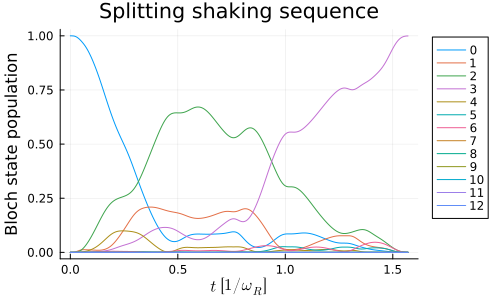

In [122]:
#p = Plots.plot(times, pops[:,:]', labels=(-p_max:1:p_max)', legend=:outertopright, size=(500, 300))
p = Plots.plot(times, pops[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    #ylabel=L"population of momentum state $|p\rangle$"
    ylabel="Bloch state population"
)
Plots.title!(p, "Splitting shaking sequence")

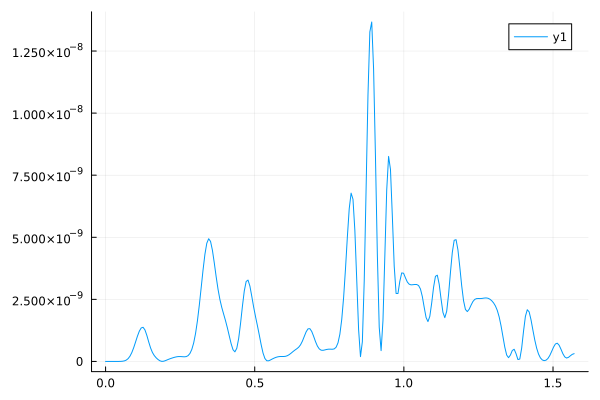

In [123]:
Plots.plot(times, pops[end,:])

blochs = bloch_states' * psi
bloch_pops = abs2.(blochs)

p = Plots.plot(times, bloch_pops[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\nu_R]$"
)
Plots.yaxis!(p, 
    ylabel=L"population of Bloch state $|B\rangle$"
)
Plots.title!(p, "Splitting shaking sequence")

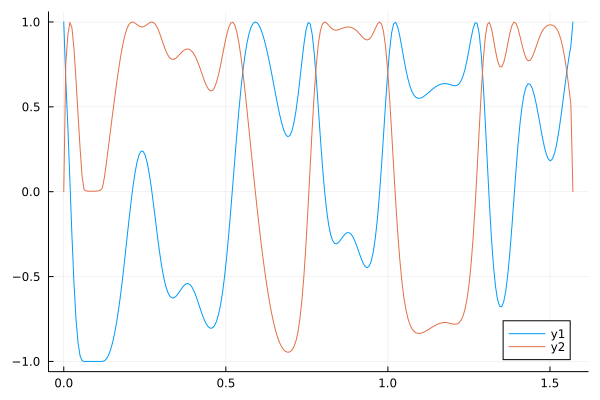

In [124]:
Plots.plot(times, Z.a')

Plots.plot(times, Z.A')

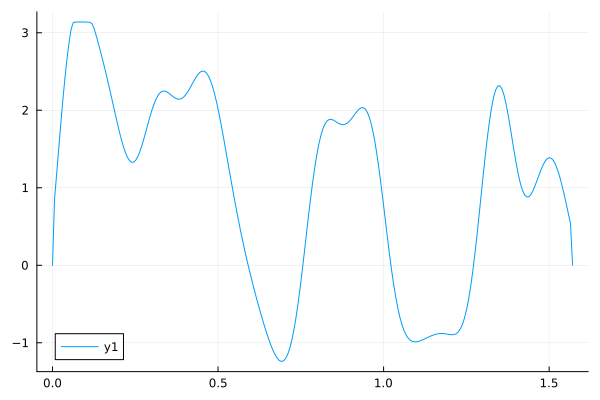

In [125]:
Plots.plot(times, Z.phi')

In [126]:
dphi = NT.derivative(Z.phi, dts)
ddphi = NT.derivative(dphi, dts);

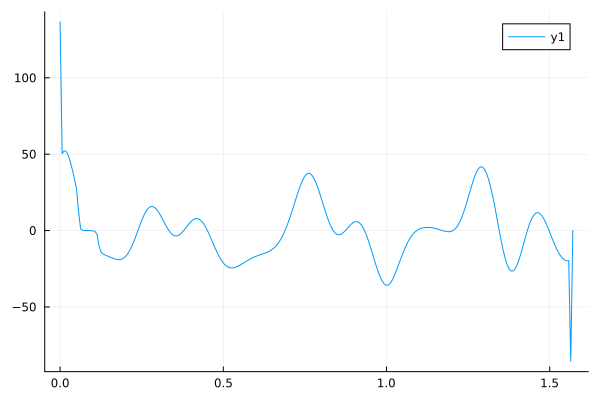

In [127]:
Plots.plot(times, dphi')

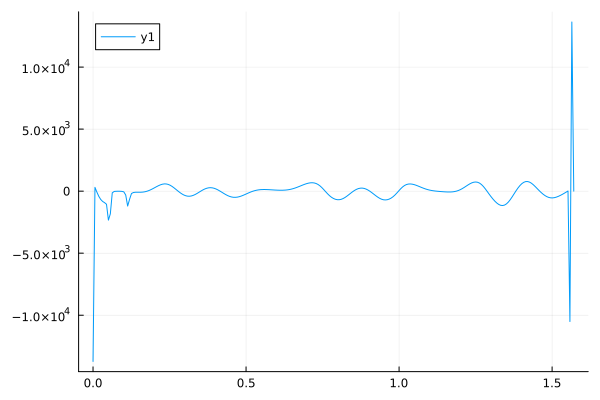

In [128]:
Plots.plot(times, ddphi')

In [129]:
times_f1 = times[div(2*T,3):end]
sin_f1 = pi/2*sin.(29.6*(times_f1 .- 0.27)) .- pi/2
times_f2 = times[1:div(2*T,3)]
sin_f2 = pi*sin.(11.5*(times_f2));

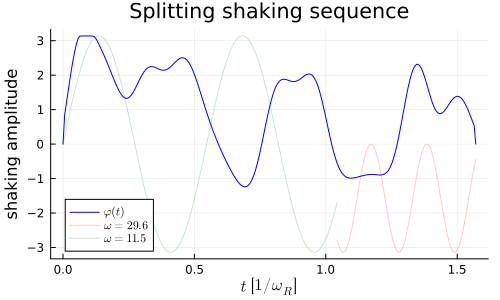

In [130]:
p = Plots.plot(times, Z.phi', linecolor=:blue, label=L"\varphi(t)", size=(500, 300))
Plots.plot!(p, times_f1, sin_f1, linecolor=:red, alpha=0.2, label=L"\omega=29.6")
Plots.plot!(p, times_f2, sin_f2, linecolor=:green, alpha=0.2, label=L"\omega=11.5")
# Plots.plot!(p, times, phase_bound.(times), linecolor=:grey, label="bound")
# Plots.plot!(p, times, -phase_bound.(times), linecolor=:grey, label="bound")
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="shaking amplitude"
)
Plots.title!(p, "Splitting shaking sequence")

In [131]:
Z_guess = Z
Z_save = NT.copy(Z)

NamedTrajectories.StructNamedTrajectory.NamedTrajectory{Float64}([1.0 0.9999084954304601 … 0.004528065990464611 0.005503632420094345; 0.0 2.7569593149763756e-20 … -0.0013016813323870778 0.0006081285362557518; … ; 0.0 0.8579329807758791 … 0.538321260488175 0.0; 0.006283185307179605 0.006283185307179605 … 0.006283185307179605 0.006283185307179605], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0003575972578258605, -0.006139324384593934, -0.0005092340244335443, 0.0016150441275339085, 0.0003479860757341304, -4.198892034855199e-6, 1.0, 0.0, 0.0, 0.006283185307179605], 251, :dts, 30, (psi_iso = 26, a = 2, phi = 1, dts = 1, states = 29, controls = 1), (phi = ([-3.141592653589793], [3.141592653589793]), dts = ([0.006283185307179605], [0.006283185307179605])), (psi_iso = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], phi = [0.0]), (phi = [0.0],), NamedTuple(), (psi_iso = 1:26, a = 27:28, phi = 29:29, dts = 30:30, states = [1, 2

In [136]:
import JLD2

In [137]:
duration_wr = round(duration/2pi; digits=2)

0.25

In [138]:
duration = sum(Z.dts) - Z.dts[end]
duration_wr = round(duration/2pi; digits=2)
s = """
Final infidelity (Bloch 3) in %:
$(J1.L(Z.datavec, Z))
"""
write("$(duration_wr)wr.txt", s)

53

In [139]:
JLD2.save("interferometer/split_bloch3_$(duration_wr)wr.jld2", Z)

In [132]:
function fourier_time_freq(data_time, times, freqs)
    dts = times[2:end] - times[1:end-1]
    push!(dts, dts[end])
    ft_mat = exp.(2im*pi*freqs*times')
    data_freq = (dts' .* ft_mat) * data_time / sqrt.(2pi)
    return data_freq
end

fourier_time_freq (generic function with 1 method)

In [133]:
slice = 1:T #div(2*T,3):T

1:251

In [134]:
freqs = collect(0:0.1:80)
phi_ft = fourier_time_freq(Z.phi[1,slice], times[slice], freqs/2pi);

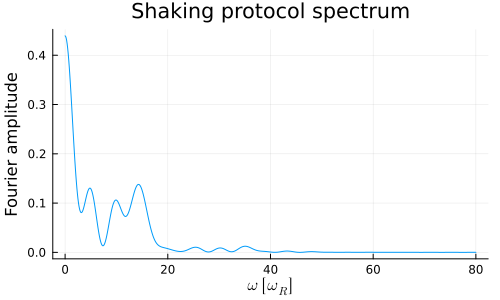

In [135]:
p = Plots.plot(freqs, abs2.(phi_ft), size=(500, 300), label=nothing)
Plots.xaxis!(p, 
    xlabel=L"$\omega$ $[\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="Fourier amplitude"
)
Plots.title!(p, "Shaking protocol spectrum")

In [ ]:
dphi = NT.derivative(Z.phi, dts)

In [ ]:
Plots.plot(times, dphi')

In [ ]:
ddphi = NT.derivative(dphi, dts)

In [ ]:
Plots.plot(times, ddphi')

# mirror (free rel phase)

In [ ]:
V = 10.
trunc = 11
# E_R [kHz] found in Weidner thesis
system = ShakenLatticeSystem1D(V, trunc; bloch_basis=true, bloch_transformation_trunc=2*trunc)
# middle index of statevector where p = 0
mid = system.params[:mid]
dim = system.params[:dim]
E_R = system.params[:E_R]
#E_R = 1/0.05
#print("time unit $(1/E_R) ms\nE_R = $E_R kHz")

In [ ]:
duration = 2pi * 1.0 # in units of 1/E_R

T = 1001
dt = duration / (T-1)
dts = zeros(T) .+ dt
dt_bound = (dt, dt)
times = cumsum(dts) - dts
duration

In [ ]:
a_bound = fill(1.0, 2)
phi_bound = [1.0 * pi]
#dphi_bound = [100.]
#ddphi_bound = [3000.]

phi = collect((sin.(11.5 *times) + sin.(20.0 * times) + sin.(27.0 * times))')
#phi = rand(1, T)
a = vcat(cos.(phi), sin.(phi))

dphi = NT.derivative(phi, dts)
ddphi = NT.derivative(dphi, dts)

In [ ]:
Z1 = NT.load_traj("./interferometer/bloch_7_to_3.jld2")
Z2 = NT.load_traj("./interferometer/mirror_victor2.jld2")

In [ ]:
Z1.dts, Z2.dts

In [ ]:
a, dts = get_interferometer(Z1, Z2, [])
times = cumsum(dts) - dts
T = length(times)

In [ ]:
Z = NT.load_traj("./interferometer/mirror_bloch7_bitshorter.jld2")

In [ ]:
a, dts = Z.a, vec(Z.dts)
phi = collect(atan.(a[2,:], a[1,:])')

slice = 1:length(dts)
a = a[:,slice]
dts = dts[slice]
phi = phi[:,slice]

times = cumsum(dts) - dts
duration = times[end]
T = length(times)

T_new = 600
dt_new = duration[end]/(T_new-1)
dts_new = fill(dt_new, T_new);

a = interpolate_controls(a, dts, dts_new)
times = cumsum(dts_new) - dts_new;

In [ ]:
duration = times[end]
T = length(times)
dt = duration/(T-1)
dt_bound = (dt, dt)
T

In [ ]:
a_bound = fill(1.0, 2)
phi_bound = [1*pi]
ddphi_bound = [1000.]

dphi = NT.derivative(phi, dts)
ddphi = NT.derivative(dphi, dts)

In [ ]:
Plots.plot(times, a')

In [ ]:
Plots.plot(times, phi')

In [ ]:
Plots.plot(times, dphi')

In [ ]:
Plots.plot(times, ddphi')

In [ ]:
p = Plots.plot(times, phi', linecolor=:blue, label=L"\varphi(t)", size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="shaking amplitude"
)
Plots.title!(p, L"Mirror $|7\rangle$ (guess)")

psi0 = zeros(system.params[:dim])
psi0[mid] = 0.
psi0[mid-1] = sqrt(0.5)
psi0[mid+1] = sqrt(0.5)
normalize!(psi0)

#####Victor solution
function get_pw_sin(sin_amps, sin_dts)
    N = length(sin_amps)
    sin_T = length(sin_dts)
    T = N*sin_T + 1
    sin_times = cumsum(sin_dts) - sin_dts
    sin_time = sin_times[end]
    dts = repeat(sin_dts, N)
    push!(dts, 0.)
    phi = zeros(T)
    for i=1:N
        phi[(i-1)*sin_T+1:i*sin_T] = (-1)^(i-1) * sin_amps[i] * sin.(pi*sin_times/sin_time)
    end
    a = zeros(2, T)
    a[1,:] = cos.(phi)
    a[2,:] = sin.(phi)
    return a, dts, cumsum(dts) - dts
end

sin_amps = [0.3926, 0.6872, 0.6872, 0.4908, 0.4908, 0.7853, 0.7853]
append!(sin_amps, sin_amps[end:-1:1]) 

freq = 11.5
sin_time = 2pi * 1/freq / 2
sin_T = 20
sin_dts = fill(sin_time / sin_T, sin_T)
a, dts, times = get_pw_sin(sin_amps, sin_dts)
T = length(times)

a_bound = fill(1., 2)
dda_bound = fill(10000., 2)
dt_bound = (dts[1], dts[1])

da = NT.derivative(a, dts)
da[:, end] = da[:, end-1]
dda = NT.derivative(da, dts)
dda[:, end] = dda[:, end-1] = dda[:, end-2]

In [ ]:
#psi0 = get_bloch_state(system; lvl=3)
bloch_subspace = [7, 8]
psip0 = QC.cavity_state(bloch_subspace[1], dim) + QC.cavity_state(bloch_subspace[2], dim)
normalize!(psip0) 
psim0 = QC.cavity_state(bloch_subspace[1], dim) - QC.cavity_state(bloch_subspace[2], dim)
normalize!(psim0)

In [ ]:
system.params[:bloch_energies]

In [ ]:
psip0_iso = QC.ket_to_iso(psip0)
psim0_iso = QC.ket_to_iso(psim0)

In [ ]:
psip_iso = QC.rollout(psip0_iso, a, dts, system; integrator=exp)
psim_iso = QC.rollout(psim0_iso, a, dts, system; integrator=exp)

In [ ]:
psip = hcat([QC.iso_to_ket(psip_iso[:,t]) for t=1:T]...)
psip_pops = abs2.(psip)
psim = hcat([QC.iso_to_ket(psim_iso[:,t]) for t=1:T]...)
psim_pops = abs2.(psim)

In [ ]:
x = 3

In [ ]:
p = Plots.plot(times, psip_pops[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    #ylabel=L"population of momentum state $|p\rangle$"
    ylabel="Bloch state population"
)
Plots.title!(p, L"Mirror $|%$(bloch_subspace[1])\rangle+|%$(bloch_subspace[2])\rangle \rightarrow |%$(bloch_subspace[1])\rangle-|%$(bloch_subspace[2])\rangle$ (guess)")

In [ ]:
p = Plots.plot(times, psim_pops[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    #ylabel=L"population of momentum state $|p\rangle$"
    ylabel="Bloch state population"
)
Plots.title!(p, L"Mirror $|%$(bloch_subspace[1])\rangle-|%$(bloch_subspace[2])\rangle \rightarrow |%$(bloch_subspace[1])\rangle+|%$(bloch_subspace[2])\rangle$ (guess)")

In [ ]:
comps = (
    psip_iso = psip_iso,
    psim_iso = psim_iso,
    a = a,
    phi = phi,
    dts = dts
)
initial = (
    psip_iso = psip0_iso,
    psim_iso = psim0_iso,
    phi = [0.]
)
final = (;
    phi = [0.]
)
goal = (;)
bounds = (
    phi = phi_bound,
    dts = dt_bound
)

Z_guess = nothing
GC.gc()
Z_guess = NT.NamedTrajectory(
    comps;
    controls=(:phi),
    timestep=:dts,
    bounds=bounds,
    initial=initial,
    final=final,
    goal=goal
)

In [ ]:
kernel = sinc_kernel(40., vec(Z_guess.dts))
convolver = LA.I(Z_guess.T) - kernel
convolver = convolver' * convolver

In [ ]:
dim = system.params[:dim]

#J = NameComponentObjective(:psi_iso, [1:dim...], [1:T...], x -> 1 - abs2.(x' * state_goal), ([1:T...] ./ T) .* 100.; is_iso=true)
J1 = QC.QuantumObjective(name=:psip_iso, goals=psim0_iso, loss=:InfidelityLoss, Q=100.0)
J1 += QC.QuantumObjective(name=:psim_iso, goals=psip0_iso, loss=:InfidelityLoss, Q=100.0)
#J += QC.QuadraticRegularizer(:dts, Z_guess, 0.01)
#J += NameComponentQuadraticRegularizer(:a, [2], Z_guess, [0.001])
#J += QC.QuadraticRegularizer(:ddphi, Z_guess, 1e-8/T)
#J += QC.QuadraticRegularizer(:dts, Z_guess, 0.01)
#J += NameComponentQuadraticRegularizer(:a, [2], Z_guess, [0.001])

# J1 = QuadraticObjective(:psi_iso, Z_guess, R; Q=200.0)
# J2 = NameComponentObjective(:psi_iso, [8, 9], [T], x -> real(x[1]'*x[2])^2, [100.0]; is_iso=true)
# J3 = QC.QuadraticRegularizer(:ddphi, Z_guess, 1e-5/T)

# convolution
J4 = QuadraticObjective(:phi, Z_guess, convolver, [1], 1:Z_guess.T; Q=50.0/T)

J = J1 + J4

In [ ]:
J.L(Z_guess.datavec, Z_guess)

In [ ]:
integrators = nothing
GC.gc()
integrators = [
    QC.QuantumStatePadeIntegrator(
        system,
        :psip_iso,
        :a,
        :dts;
        order=4
    ),
    QC.QuantumStatePadeIntegrator(
        system,
        :psim_iso,
        :a,
        :dts;
        order=4
    ),
]

In [ ]:
constraints = [
    IQPhiConstraint(:a, :phi, Z_guess),
    #LinearSincConvolutionConstraint(:phi, :dts, Z_guess, 60.)
    #OmegaAbsConstraint(1.0, Z_guess),
    #PhiSincConvolutionConstraint(:a, :dts, Z_guess, 80.),
    #PhiFunctionBoundConstraint(phase_bound, Z_guess),
    #TimeSymmetricControlConstraint(:a, Z_guess)
    #custom_bounds_constraint(:a, Z_guess, Int[], a_bound)
]

In [ ]:
# Ipopt options
options = QC.Options(
    max_iter=200,
)

In [ ]:
# defining quantum control problem
prob = nothing
GC.gc()
prob = QC.QuantumControlProblem(
    system, 
    Z_guess, 
    J, 
    integrators;
    constraints=constraints,
    options=options,
)

In [ ]:
QC.solve!(prob)

In [ ]:
Z = nothing
GC.gc()
Z = prob.trajectory

In [ ]:
Z = NT.load_traj("interferometer/mirror_bloch78_freerelphase.jld2")

In [ ]:
psip_iso_rollout = QC.rollout(psip0_iso, Z.a, Z.dts, system; integrator=exp)
psip = hcat([QC.iso_to_ket(psip_iso_rollout[:,t]) for t=1:Z.T]...)
popsp = abs2.(psip)

psim_iso_rollout = QC.rollout(psim0_iso, Z.a, Z.dts, system; integrator=exp)
psim = hcat([QC.iso_to_ket(psim_iso_rollout[:,t]) for t=1:Z.T]...)
popsm = abs2.(psim)

psi = hcat([QC.iso_to_ket(Z.psi_iso[:,t]) for t=1:T]...)
pops = hcat([abs2.(QC.iso_to_ket(Z.psi_iso[:,t])) for t=1:T]...)

In [ ]:
abs2.(psip[:,end]' * psim0)

In [ ]:
abs2.(psim[:,end]' * psip0)

In [ ]:
times = cumsum(Z.dts[1,:]) - Z.dts[1,:]

In [ ]:
p = Plots.plot(times, popsp[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="Bloch state population"
)
Plots.title!(p, L"Mirror $|%$(bloch_subspace[1])\rangle+|%$(bloch_subspace[2])\rangle \rightarrow |%$(bloch_subspace[1])\rangle-|%$(bloch_subspace[2])\rangle$")

In [ ]:
p = Plots.plot(times, popsm[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="Bloch state population"
)
Plots.title!(p, L"Mirror $|%$(bloch_subspace[1])\rangle-|%$(bloch_subspace[2])\rangle \rightarrow |%$(bloch_subspace[1])\rangle+|%$(bloch_subspace[2])\rangle$")

In [ ]:
Plots.plot(times, Z.a')

In [ ]:
Plots.plot(times, Z.phi')

In [ ]:
Plots.plot(times, Z.dphi')

In [ ]:
Plots.plot(times, Z.ddphi')

In [ ]:
p = Plots.plot(times, Z.phi', linecolor=:blue, label=L"\varphi(t)", size=(700, 300))
# Plots.plot!(p, times, phase_bound.(times), linecolor=:grey, label="bound")
# Plots.plot!(p, times, -phase_bound.(times), linecolor=:grey, label="bound")
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="shaking amplitude"
)
Plots.title!(p, L"Mirror $|7\rangle$")

In [ ]:
pops[:,end]

In [ ]:
Plots.plot(times, acos.(Z.a[1,:]))

In [ ]:
Z_guess = Z
Z_save = deepcopy(Z)

In [ ]:
Z_guess = trajectory_shrink_extend(Z, 1001)

In [ ]:
import JLD2

In [ ]:
JLD2.save("interferometer/mirror_bloch78_freerelphase.jld2", Z)

In [ ]:
function fourier_time_freq(data_time, times, freqs)
    dts = times[2:end] - times[1:end-1]
    push!(dts, dts[end])
    ft_mat = exp.(2im*pi*freqs*times')
    data_freq = (dts' .* ft_mat) * data_time / sqrt.(2pi)
    return data_freq
end

In [ ]:
freqs = collect(0:0.1:60)
phi_ft = fourier_time_freq(Z.a[2,:], times, freqs/(2pi));
#phi_ft = fourier_time_freq(phi, times, freqs/(2pi));

In [ ]:
Plots.plot(freqs, abs2.(phi_ft))#, ylims=(0.0, 0.01))

# mirror (Z gate)

In [140]:
V = 10.
trunc = 13
# E_R [kHz] found in Weidner thesis
system = ShakenLatticeSystem1D(V, trunc; bloch_basis=true, bloch_transformation_trunc=3*trunc, odd_even_fix_above_degeneracy_diff=1e-20)
# middle index of statevector where p = 0
mid = system.params[:mid]
dim = system.params[:dim]
E_R = system.params[:E_R]
#E_R = 1/0.05
#print("time unit $(1/E_R) ms\nE_R = $E_R kHz")

8.939026187912745

In [142]:
duration = 2pi * 0.25 # in units of 1/E_R

T = 251
dt = duration / (T-1)
dts = zeros(T) .+ dt
dt_bound = (dt, dt)
times = cumsum(dts) - dts
duration

1.5707963267948966

In [143]:
a_bound = fill(1.0, 2)
phi_bound = [1.0 * pi]
#dphi_bound = [100.]
#ddphi_bound = [3000.]

#phi = collect((sin.(11.5 *times) + sin.(20.0 * times) + sin.(27.0 * times))')
phi = rand(1, T)
phi = zeros(1, T)
a = vcat(cos.(phi), sin.(phi))

dphi = NT.derivative(phi, dts)
ddphi = NT.derivative(dphi, dts)

1×251 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

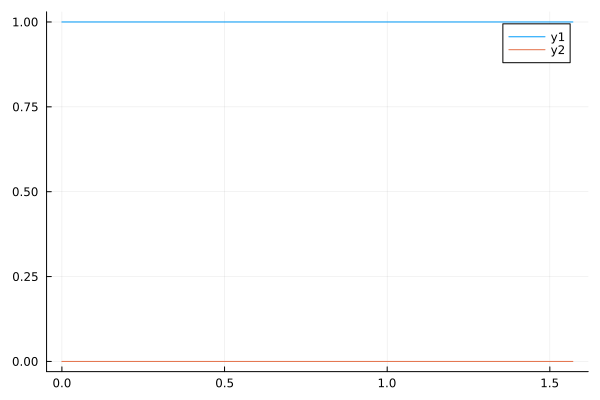

In [144]:
Plots.plot(times, a')

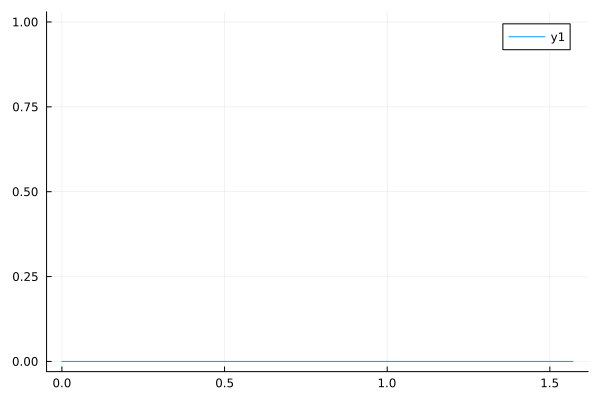

In [145]:
Plots.plot(times, phi')

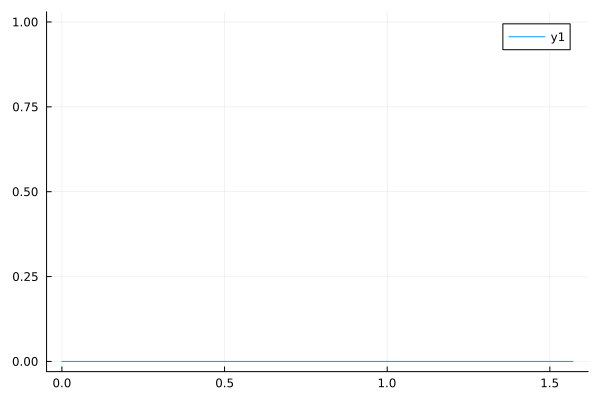

In [146]:
Plots.plot(times, dphi')

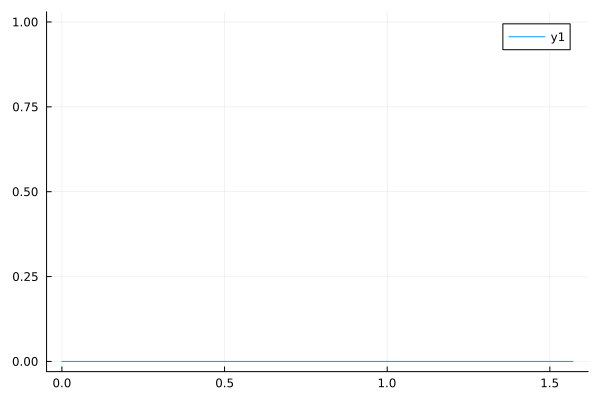

In [147]:
Plots.plot(times, ddphi')

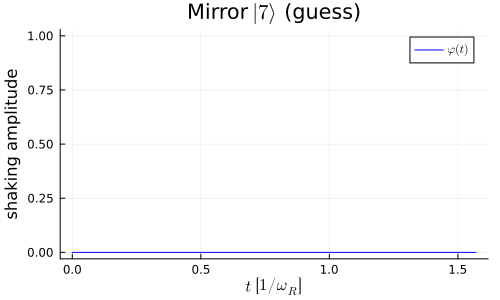

In [148]:
p = Plots.plot(times, phi', linecolor=:blue, label=L"\varphi(t)", size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="shaking amplitude"
)
Plots.title!(p, L"Mirror $|7\rangle$ (guess)")

psi0 = zeros(system.params[:dim])
psi0[mid] = 0.
psi0[mid-1] = sqrt(0.5)
psi0[mid+1] = sqrt(0.5)
normalize!(psi0)

#####Victor solution
function get_pw_sin(sin_amps, sin_dts)
    N = length(sin_amps)
    sin_T = length(sin_dts)
    T = N*sin_T + 1
    sin_times = cumsum(sin_dts) - sin_dts
    sin_time = sin_times[end]
    dts = repeat(sin_dts, N)
    push!(dts, 0.)
    phi = zeros(T)
    for i=1:N
        phi[(i-1)*sin_T+1:i*sin_T] = (-1)^(i-1) * sin_amps[i] * sin.(pi*sin_times/sin_time)
    end
    a = zeros(2, T)
    a[1,:] = cos.(phi)
    a[2,:] = sin.(phi)
    return a, dts, cumsum(dts) - dts
end

sin_amps = [0.3926, 0.6872, 0.6872, 0.4908, 0.4908, 0.7853, 0.7853]
append!(sin_amps, sin_amps[end:-1:1]) 

freq = 11.5
sin_time = 2pi * 1/freq / 2
sin_T = 20
sin_dts = fill(sin_time / sin_T, sin_T)
a, dts, times = get_pw_sin(sin_amps, sin_dts)
T = length(times)

a_bound = fill(1., 2)
dda_bound = fill(10000., 2)
dt_bound = (dts[1], dts[1])

da = NT.derivative(a, dts)
da[:, end] = da[:, end-1]
dda = NT.derivative(da, dts)
dda[:, end] = dda[:, end-1] = dda[:, end-2]

In [ ]:
#psi0 = get_bloch_state(system; lvl=3)
bloch_subspace = [7, 8]
psi0 = QC.cavity_state(bloch_subspace[1], dim)
psip0 = QC.cavity_state(bloch_subspace[1], dim) + QC.cavity_state(bloch_subspace[2], dim)
normalize!(psip0) 
psim0 = QC.cavity_state(bloch_subspace[1], dim) - QC.cavity_state(bloch_subspace[2], dim)
normalize!(psim0)

In [ ]:
system.params[:bloch_energies]

In [ ]:
psi0_iso = QC.ket_to_iso(psi0)
psip0_iso = QC.ket_to_iso(psip0)

In [ ]:
psi_iso = QC.rollout(psi0_iso, a, dts, system; integrator=exp)
psip_iso = QC.rollout(psip0_iso, a, dts, system; integrator=exp)

In [ ]:
psi_iso += rand(size(psi_iso)...)
psip_iso += rand(size(psip_iso)...)

In [ ]:
psi = hcat([QC.iso_to_ket(psi_iso[:,t]) for t=1:T]...)
psi_pops = abs2.(psi)
psip = hcat([QC.iso_to_ket(psip_iso[:,t]) for t=1:T]...)
psip_pops = abs2.(psip)

In [ ]:
p = Plots.plot(times, psi_pops[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    #ylabel=L"population of momentum state $|p\rangle$"
    ylabel="Bloch state population"
)
Plots.title!(p, L"Mirror $|%$(bloch_subspace[1])\rangle \rightarrow |%$(bloch_subspace[1])\rangle$ (guess)")

In [ ]:
p = Plots.plot(times, psip_pops[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    #ylabel=L"population of momentum state $|p\rangle$"
    ylabel="Bloch state population"
)
Plots.title!(p, L"Mirror $|%$(bloch_subspace[1])\rangle+|%$(bloch_subspace[2])\rangle \rightarrow |%$(bloch_subspace[1])\rangle-|%$(bloch_subspace[2])\rangle$ (guess)")

In [ ]:
comps = (
    psi_iso = psi_iso,
    psip_iso = psip_iso,
    a = a,
    phi = phi,
    dts = dts
)
initial = (
    psi_iso = psi0_iso,
    psip_iso = psip0_iso,
    phi = [0.]
)
final = (;
    phi = [0.]
)
goal = (;)
bounds = (
    phi = phi_bound,
    dts = dt_bound
)

Z_guess = nothing
GC.gc()
Z_guess = NT.NamedTrajectory(
    comps;
    controls=(:phi),
    timestep=:dts,
    bounds=bounds,
    initial=initial,
    final=final,
    goal=goal
)

In [ ]:
kernel = sinc_kernel(40., vec(Z_guess.dts))
convolver = LA.I(Z_guess.T) - kernel
convolver = convolver' * convolver

In [ ]:
dim = system.params[:dim]

#J = NameComponentObjective(:psi_iso, [1:dim...], [1:T...], x -> 1 - abs2.(x' * state_goal), ([1:T...] ./ T) .* 100.; is_iso=true)
J1 = QC.QuantumObjective(name=:psip_iso, goals=QC.ket_to_iso(psim0), loss=:InfidelityLoss, Q=100.0)
J1 += QC.QuantumObjective(name=:psi_iso, goals=psi0_iso, loss=:InfidelityLoss, Q=100.0)
#J += QC.QuadraticRegularizer(:dts, Z_guess, 0.01)
#J += NameComponentQuadraticRegularizer(:a, [2], Z_guess, [0.001])
#J += QC.QuadraticRegularizer(:ddphi, Z_guess, 1e-8/T)
#J += QC.QuadraticRegularizer(:dts, Z_guess, 0.01)
#J += NameComponentQuadraticRegularizer(:a, [2], Z_guess, [0.001])

# J1 = QuadraticObjective(:psi_iso, Z_guess, R; Q=200.0)
# J2 = NameComponentObjective(:psi_iso, [8, 9], [T], x -> real(x[1]'*x[2])^2, [100.0]; is_iso=true)
# J3 = QC.QuadraticRegularizer(:ddphi, Z_guess, 1e-5/T)

# convolution
J4 = QuadraticObjective(:phi, Z_guess, convolver, [1], 1:Z_guess.T; Q=50.0/T)

J = J1 + J4

In [ ]:
J.L(Z_guess.datavec, Z_guess)

In [ ]:
integrators = nothing
GC.gc()
integrators = [
    QC.QuantumStatePadeIntegrator(
        system,
        :psi_iso,
        :a,
        :dts;
        order=4
    ),
    QC.QuantumStatePadeIntegrator(
        system,
        :psip_iso,
        :a,
        :dts;
        order=4
    ),
]

In [ ]:
constraints = [
    IQPhiConstraint(:a, :phi, Z_guess),
    QC.ComplexModulusContraint(
        R=sqrt(0.1),
        comps=Z_guess.components[:psi_iso][[3, 3+dim]],
        times=[div(Z_guess.T, 2)],
        zdim=Z_guess.dim,
        T=Z_guess.T,
        negated=true
    )
    #LinearSincConvolutionConstraint(:phi, :dts, Z_guess, 60.)
    #OmegaAbsConstraint(1.0, Z_guess),
    #PhiSincConvolutionConstraint(:a, :dts, Z_guess, 80.),
    #PhiFunctionBoundConstraint(phase_bound, Z_guess),
    #TimeSymmetricControlConstraint(:a, Z_guess)
    #custom_bounds_constraint(:a, Z_guess, Int[], a_bound)
]

In [ ]:
# Ipopt options
options = QC.Options(
    max_iter=200,
)

In [ ]:
# defining quantum control problem
prob = nothing
GC.gc()
prob = QC.QuantumControlProblem(
    system, 
    Z_guess, 
    J, 
    integrators;
    constraints=constraints,
    options=options,
)

In [ ]:
QC.solve!(prob)

In [ ]:
Z = nothing
GC.gc()
Z = prob.trajectory

In [ ]:
psi_iso_rollout = QC.rollout(psi0_iso, Z.a, Z.dts, system; integrator=exp)
psi = hcat([QC.iso_to_ket(psi_iso_rollout[:,t]) for t=1:Z.T]...)
pops = abs2.(psi)

psip_iso_rollout = QC.rollout(psip0_iso, Z.a, Z.dts, system; integrator=exp)
psip = hcat([QC.iso_to_ket(psip_iso_rollout[:,t]) for t=1:Z.T]...)
popsp = abs2.(psip)

psi = hcat([QC.iso_to_ket(Z.psi_iso[:,t]) for t=1:T]...)
pops = hcat([abs2.(QC.iso_to_ket(Z.psi_iso[:,t])) for t=1:T]...)

In [ ]:
abs2.(psi[:,end]' * psi0)

In [ ]:
abs2.(psip[:,end]' * psim0)

In [ ]:
times = cumsum(Z.dts[1,:]) - Z.dts[1,:]

In [ ]:
p = Plots.plot(times, pops[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="Bloch state population"
)
Plots.title!(p, L"Mirror $|%$(bloch_subspace[1])\rangle \rightarrow |%$(bloch_subspace[1])\rangle$")

In [ ]:
p = Plots.plot(times, popsp[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="Bloch state population"
)
Plots.title!(p, L"Mirror $|%$(bloch_subspace[1])\rangle+|%$(bloch_subspace[2])\rangle \rightarrow |%$(bloch_subspace[1])\rangle-|%$(bloch_subspace[2])\rangle$")

In [ ]:
Plots.plot(times, Z.a')

In [ ]:
Plots.plot(times, Z.phi')

In [ ]:
Plots.plot(times, Z.dphi')

In [ ]:
Plots.plot(times, Z.ddphi')

In [ ]:
p = Plots.plot(times, Z.phi', linecolor=:blue, label=L"\varphi(t)", size=(500, 300))
# Plots.plot!(p, times, phase_bound.(times), linecolor=:grey, label="bound")
# Plots.plot!(p, times, -phase_bound.(times), linecolor=:grey, label="bound")
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="shaking amplitude"
)
Plots.title!(p, L"Mirror $|7\rangle$")

In [ ]:
pops[:,end]

In [ ]:
Plots.plot(times, acos.(Z.a[1,:]))

In [ ]:
Z_guess = Z
Z_save = deepcopy(Z)

In [ ]:
Z_guess = trajectory_shrink_extend(Z, 1001)

In [ ]:
import JLD2

In [ ]:
JLD2.save("interferometer/mirror_bloch78_Z.jld2", Z)

In [ ]:
function fourier_time_freq(data_time, times, freqs)
    dts = times[2:end] - times[1:end-1]
    push!(dts, dts[end])
    ft_mat = exp.(2im*pi*freqs*times')
    data_freq = (dts' .* ft_mat) * data_time / sqrt.(2pi)
    return data_freq
end

In [ ]:
freqs = collect(0:0.1:60)
phi_ft = fourier_time_freq(Z.a[2,:], times, freqs/(2pi));
#phi_ft = fourier_time_freq(phi, times, freqs/(2pi));

In [ ]:
Plots.plot(freqs, abs2.(phi_ft))#, ylims=(0.0, 0.01))

# bring to hold

In [149]:
V = 10.
trunc = 13
# E_R [kHz] found in Weidner thesis
system = ShakenLatticeSystem1D(V, trunc; bloch_basis=true, bloch_transformation_trunc=3*trunc, odd_even_fix_above_degeneracy_diff=1e-20)
# middle index of statevector where p = 0
mid = system.params[:mid]
dim = system.params[:dim]
E_R = system.params[:E_R]
#E_R = 1/0.05
#print("time unit $(1/E_R) ms\nE_R = $E_R kHz")

8.939026187912745

In [150]:
duration = 2pi * 0.25 # in units of 1/E_R

T = 251
dt = duration / (T-1)
dts = zeros(T) .+ dt
dt_bound = (dt, dt)
times = cumsum(dts) - dts
duration

1.5707963267948966

In [151]:
a_bound = fill(1.0, 2)
phi_bound = [1.0 * pi]
#dphi_bound = [100.]
#ddphi_bound = [3000.]

#phi = collect((sin.(11.5 *times) + sin.(20.0 * times) + sin.(27.0 * times))')
phi = rand(1, T)
phi = zeros(1, T)
a = vcat(cos.(phi), sin.(phi))

dphi = NT.derivative(phi, dts)
ddphi = NT.derivative(dphi, dts)

1×251 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

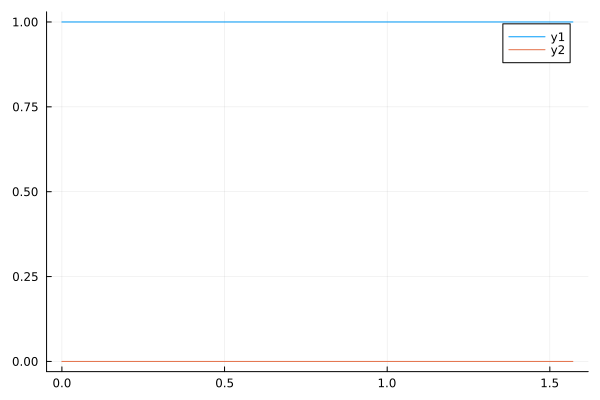

In [152]:
Plots.plot(times, a')

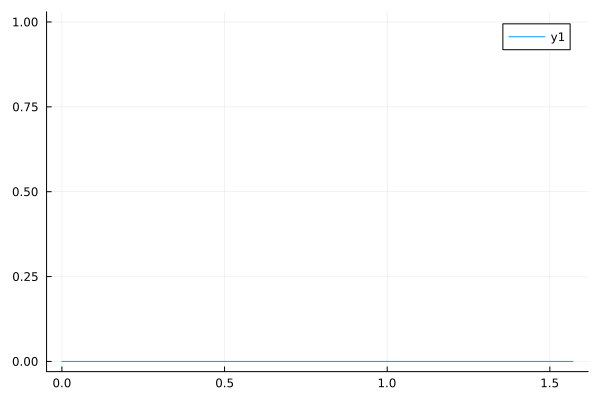

In [153]:
Plots.plot(times, phi')

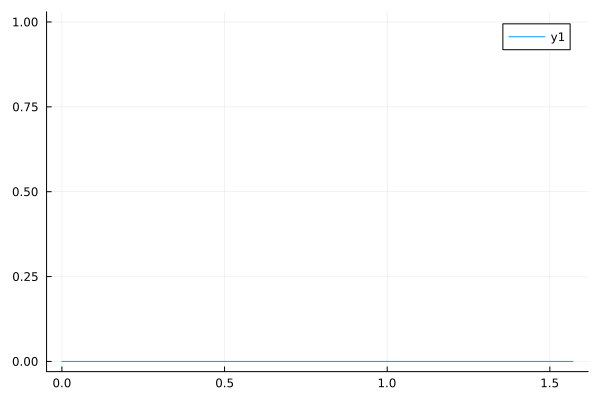

In [154]:
Plots.plot(times, dphi')

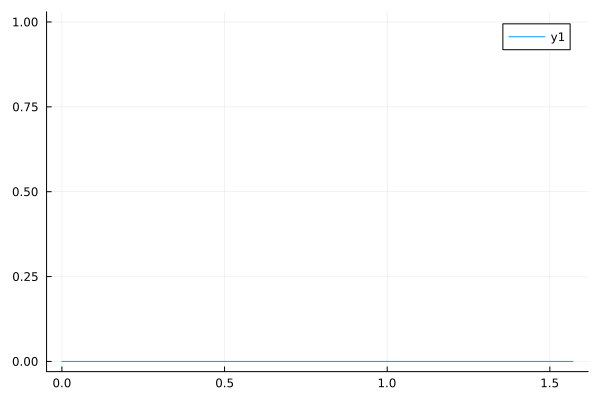

In [155]:
Plots.plot(times, ddphi')

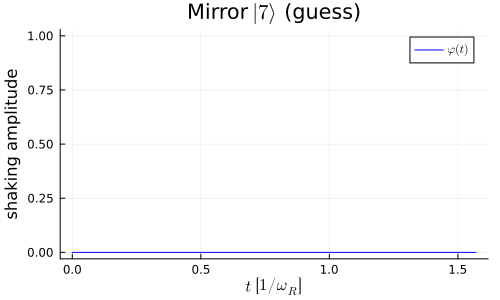

In [156]:
p = Plots.plot(times, phi', linecolor=:blue, label=L"\varphi(t)", size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="shaking amplitude"
)
Plots.title!(p, L"Mirror $|7\rangle$ (guess)")

psi0 = zeros(system.params[:dim])
psi0[mid] = 0.
psi0[mid-1] = sqrt(0.5)
psi0[mid+1] = sqrt(0.5)
normalize!(psi0)

#####Victor solution
function get_pw_sin(sin_amps, sin_dts)
    N = length(sin_amps)
    sin_T = length(sin_dts)
    T = N*sin_T + 1
    sin_times = cumsum(sin_dts) - sin_dts
    sin_time = sin_times[end]
    dts = repeat(sin_dts, N)
    push!(dts, 0.)
    phi = zeros(T)
    for i=1:N
        phi[(i-1)*sin_T+1:i*sin_T] = (-1)^(i-1) * sin_amps[i] * sin.(pi*sin_times/sin_time)
    end
    a = zeros(2, T)
    a[1,:] = cos.(phi)
    a[2,:] = sin.(phi)
    return a, dts, cumsum(dts) - dts
end

sin_amps = [0.3926, 0.6872, 0.6872, 0.4908, 0.4908, 0.7853, 0.7853]
append!(sin_amps, sin_amps[end:-1:1]) 

freq = 11.5
sin_time = 2pi * 1/freq / 2
sin_T = 20
sin_dts = fill(sin_time / sin_T, sin_T)
a, dts, times = get_pw_sin(sin_amps, sin_dts)
T = length(times)

a_bound = fill(1., 2)
dda_bound = fill(10000., 2)
dt_bound = (dts[1], dts[1])

da = NT.derivative(a, dts)
da[:, end] = da[:, end-1]
dda = NT.derivative(da, dts)
dda[:, end] = dda[:, end-1] = dda[:, end-2]

In [184]:
#psi0 = get_bloch_state(system; lvl=3)
bloch_subspace = [3, 4]
psi00 = QC.cavity_state(bloch_subspace[1], dim)
psi10 = QC.cavity_state(bloch_subspace[2], dim)

13-element Vector{ComplexF64}:
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

In [185]:
system.params[:bloch_energies]

39-element Vector{Float64}:
   -2.153078342041735
    3.4924743667389517
    5.613041084867151
   16.194837346915975
   16.227316187360763
   36.089436879709716
   36.08946965587397
   64.04962982471427
   64.04962983201821
  100.03157230514728
  100.03157230514785
  144.02185531525708
  144.0218553152571
    ⋮
  784.0039910728271
  784.0039910728271
  900.0034760929894
  900.0034760929907
 1024.0030547466874
 1024.0030547466897
 1156.0027056320225
 1156.002705632023
 1296.002418994283
 1296.002418994286
 1444.0422238741496
 1444.04222387415

In [186]:
psi00_iso = QC.ket_to_iso(psi00)
psi10_iso = QC.ket_to_iso(psi10)

26-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [187]:
psi0_iso = QC.rollout(psi00_iso, a, dts, system; integrator=exp)
psi1_iso = QC.rollout(psi10_iso, a, dts, system; integrator=exp)

26×251 Matrix{Float64}:
 0.0   7.08777e-19   2.82762e-18   6.33412e-18  …  -2.69794e-16  -2.65092e-16
 0.0  -1.46177e-18  -5.8312e-18   -1.30608e-17      8.40607e-17   7.03136e-17
 0.0   3.63406e-18   1.4494e-17    3.24534e-17     -1.40535e-15  -1.39735e-15
 0.0  -1.5662e-16   -6.23234e-16  -1.39015e-15     -8.73168e-14  -1.25335e-13
 1.0   0.994807      0.979281      0.953583         0.967636      0.936926
 0.0   5.28374e-20   2.08096e-19   4.56185e-19  …  -7.4171e-20   -1.37808e-19
 0.0   3.64999e-18   1.43752e-17   3.15131e-17     -5.1245e-18   -9.51846e-18
 0.0   5.27489e-19   2.02019e-18   4.22323e-18      1.39953e-19  -4.23964e-19
 0.0  -4.33533e-19  -1.66036e-18  -3.47099e-18     -1.15025e-19   3.48448e-19
 0.0  -2.50133e-20  -9.02335e-20  -1.69957e-19     -1.75698e-20   8.32108e-21
 0.0  -1.97221e-20  -7.11456e-20  -1.34004e-19  …  -1.38531e-20   6.56085e-21
 0.0   9.99661e-24   3.22402e-23   4.94153e-23      8.57031e-24  -1.65662e-24
 0.0   3.57379e-21   1.15259e-20   1.7666e-

In [188]:
psi0_iso += rand(size(psi0_iso)...)
psi1_iso += rand(size(psi1_iso)...)

26×251 Matrix{Float64}:
 0.303997   0.255055    0.742057    …  0.483583  0.411719    0.214782
 0.786555   0.309625    0.38867        0.562588  0.387627    0.73465
 0.678151   0.086707    0.370068       0.525103  0.470702    0.302921
 0.615718   0.333757    0.809935       0.684616  0.632252    0.394454
 1.68446    1.4448      1.14136        1.56632   1.91958     1.86563
 0.893508   0.0797181   0.26076     …  0.431654  0.0297323   0.904303
 0.61615    0.00623399  0.749801       0.214618  0.0901735   0.356514
 0.99522    0.203567    0.341221       0.629067  0.882977    0.817669
 0.206643   0.285651    0.00972086     0.161549  0.432261    0.349294
 0.845501   0.130622    0.336764       0.426403  0.0248329   0.574102
 0.814784   0.477674    0.254408    …  0.754702  0.794719    0.969823
 0.266603   0.95314     0.509595       0.983194  0.416365    0.996371
 0.679052   0.645499    0.834823       0.993342  0.548733    0.879637
 0.574437   0.20026     0.0450465      0.911187  0.554474    0.66106

In [189]:
psi0 = hcat([QC.iso_to_ket(psi0_iso[:,t]) for t=1:T]...)
psi0_pops = abs2.(psi0)
psi1 = hcat([QC.iso_to_ket(psi1_iso[:,t]) for t=1:T]...)
psi1_pops = abs2.(psi1)

13×251 Matrix{Float64}:
 0.422391  0.105157  0.552678   0.281655    …  1.06411   0.476954   0.483131
 0.837612  0.2645    0.843405   0.700911       0.397983  1.08205    1.11889
 0.465438  0.78461   0.259958   0.255381       0.307356  1.00151    0.467014
 0.76876   0.148773  1.06013    0.549986       1.41242   0.402358   0.508489
 2.87543   2.14277   1.58676    1.32231        2.50119   4.13178    3.48242
 1.42134   0.563204  0.835897   1.28669     …  0.970983  0.0119366  1.5442
 0.727866  0.762649  0.562789   0.305506       0.135331  0.76271    0.678257
 1.03737   0.715745  0.146178   0.810049       0.473464  1.09485    0.697823
 0.68867   0.559529  0.853117   1.27149        0.498564  0.804977   0.340488
 1.20999   0.534253  0.363746   0.00889451     0.210642  0.58589    0.534299
 1.11022   0.238753  0.0730987  1.05169     …  0.595878  1.51751    1.25458
 0.492713  1.44839   0.418834   1.31816        1.40446   0.177896   1.47716
 0.897187  0.488673  1.05796    0.019992       1.3555    1

In [190]:
p = Plots.plot(times, psi0_pops[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    #ylabel=L"population of momentum state $|p\rangle$"
    ylabel="Bloch state population"
)
Plots.title!(p, L"Mirror $|%$(bloch_subspace[1])\rangle \rightarrow |%$(bloch_subspace[1])\rangle$ (guess)")

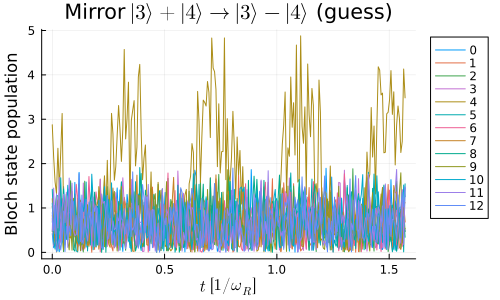

In [191]:
p = Plots.plot(times, psi1_pops[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    #ylabel=L"population of momentum state $|p\rangle$"
    ylabel="Bloch state population"
)
Plots.title!(p, L"Mirror $|%$(bloch_subspace[1])\rangle+|%$(bloch_subspace[2])\rangle \rightarrow |%$(bloch_subspace[1])\rangle-|%$(bloch_subspace[2])\rangle$ (guess)")

In [192]:
comps = (
    psi0_iso = psi0_iso,
    psi1_iso = psi1_iso,
    a = a,
    phi = phi,
    dts = dts
)
initial = (
    psi0_iso = psi00_iso,
    psi1_iso = psi10_iso,
    phi = [0.]
)
final = (;
    phi = [0.]
)
goal = (;)
bounds = (
    phi = phi_bound,
    dts = dt_bound
)

Z_guess = nothing
GC.gc()
Z_guess = NT.NamedTrajectory(
    comps;
    controls=(:phi),
    timestep=:dts,
    bounds=bounds,
    initial=initial,
    final=final,
    goal=goal
)

NamedTrajectories.StructNamedTrajectory.NamedTrajectory{Float64}([0.30500506414559003 0.15722867843386046 … 0.4908117191161733 0.7708141716700208; 0.3265400494699999 0.2498752333187343 … 0.7183974718071795 0.45714533259807627; … ; 0.0 0.0 … 0.0 0.0; 0.006283185307179587 0.006283185307179587 … 0.006283185307179587 0.006283185307179587], [0.30500506414559003, 0.3265400494699999, 0.16518051036149617, 1.183510663018794, 0.8332108760734526, 0.42826619075218897, 0.28364181286838697, 0.44596282574542867, 0.814896717018472, 0.594026941187672  …  0.1709994127368345, 0.467420423411672, 0.45244403799041455, 0.5603743892182124, 0.6959928598956625, 0.8261352457815391, 1.0, 0.0, 0.0, 0.006283185307179587], 251, :dts, 56, (psi0_iso = 26, psi1_iso = 26, a = 2, phi = 1, dts = 1, states = 55, controls = 1), (phi = ([-3.141592653589793], [3.141592653589793]), dts = ([0.006283185307179587], [0.006283185307179587])), (psi0_iso = [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0,

In [193]:
kernel = sinc_kernel(40., vec(Z_guess.dts))
convolver = LA.I(Z_guess.T) - kernel
convolver = convolver' * convolver

251×251 Matrix{Float64}:
  0.882997     -0.112604     -0.105921     …  -0.0016762    -0.00218867
 -0.112604      0.889264     -0.106535        -0.00110439   -0.0016762
 -0.105921     -0.106535      0.895142        -0.000483035  -0.00107922
 -0.0972164    -0.100171     -0.100966         0.000150186  -0.000434087
 -0.0868281    -0.0918977    -0.0950196        0.000757039   0.000220019
 -0.0751495    -0.0820352    -0.0872557    …   0.00130106    0.000843522
 -0.0626137    -0.0709582    -0.077976         0.0017498     0.00139887
 -0.0496739    -0.0590778    -0.0675338        0.00207682    0.00185286
 -0.0367832    -0.0468239    -0.0563178        0.00226329    0.00217867
 -0.0243756    -0.034626     -0.0447348        0.0022992     0.00235751
 -0.0128473    -0.0228945    -0.0331918    …   0.00218387    0.00237976
 -0.00254095   -0.0120041    -0.022078         0.00192608    0.00224559
  0.00626754   -0.00227778   -0.0117493        0.00154341    0.00196489
  ⋮                                  

In [194]:
dim = system.params[:dim]

#J = NameComponentObjective(:psi_iso, [1:dim...], [1:T...], x -> 1 - abs2.(x' * state_goal), ([1:T...] ./ T) .* 100.; is_iso=true)
J1 = QC.QuantumObjective(name=:psi0_iso, goals=QC.ket_to_iso(QC.cavity_state(0, dim)), loss=:InfidelityLoss, Q=100.0)
J1 += QC.QuantumObjective(name=:psi1_iso, goals=QC.ket_to_iso(QC.cavity_state(1, dim)), loss=:InfidelityLoss, Q=100.0)
#J += QC.QuadraticRegularizer(:dts, Z_guess, 0.01)
#J += NameComponentQuadraticRegularizer(:a, [2], Z_guess, [0.001])
#J += QC.QuadraticRegularizer(:ddphi, Z_guess, 1e-8/T)
#J += QC.QuadraticRegularizer(:dts, Z_guess, 0.01)
#J += NameComponentQuadraticRegularizer(:a, [2], Z_guess, [0.001])

# J1 = QuadraticObjective(:psi_iso, Z_guess, R; Q=200.0)
# J2 = NameComponentObjective(:psi_iso, [8, 9], [T], x -> real(x[1]'*x[2])^2, [100.0]; is_iso=true)
# J3 = QC.QuadraticRegularizer(:ddphi, Z_guess, 1e-5/T)

# convolution
J4 = QuadraticObjective(:phi, Z_guess, convolver, [1], 1:Z_guess.T; Q=50.0/T)

J = J1 + J4

QuantumCollocation.Objectives.Objective(QuantumCollocation.Objectives.var"#1#7"{QuantumCollocation.Objectives.Objective, QuantumCollocation.Objectives.Objective}(QuantumCollocation.Objectives.Objective(QuantumCollocation.Objectives.var"#1#7"{QuantumCollocation.Objectives.Objective, QuantumCollocation.Objectives.Objective}(QuantumCollocation.Objectives.Objective(QuantumCollocation.Objectives.var"#L#21"{Vector{QuantumCollocation.Losses.InfidelityLoss}}(Core.Box((:psi0_iso,)), Core.Box(:InfidelityLoss), Core.Box([100.0]), QuantumCollocation.Losses.InfidelityLoss[QuantumCollocation.Losses.InfidelityLoss(QuantumCollocation.Losses.var"#22#25"{Vector{Float64}}([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), QuantumCollocation.Losses.var"#23#26"{QuantumCollocation.Losses.var"#22#25"{Vector{Float64}}}(QuantumCollocation.Losses.var"#22#25"{Vector{Float64}}([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [195]:
J.L(Z_guess.datavec, Z_guess)

13.198319559141236

In [196]:
integrators = nothing
GC.gc()
integrators = [
    QC.QuantumStatePadeIntegrator(
        system,
        :psi0_iso,
        :a,
        :dts;
        order=4
    ),
    QC.QuantumStatePadeIntegrator(
        system,
        :psi1_iso,
        :a,
        :dts;
        order=4
    ),
]

2-element Vector{QuantumCollocation.Integrators.QuantumStatePadeIntegrator{Float64}}:
 QuantumCollocation.Integrators.QuantumStatePadeIntegrator{Float64}(nothing, nothing, [1.160447754875659 -5.594466076454682e-15 … 9.271503567350553e-8 9.276310935102601e-8; -5.594405513746107e-15 4.482431989861644 … 4.322997308939823e-7 -4.3207569530499453e-7; … ; 9.27150356735067e-8 4.322997308939808e-7 … 143.97814034661678 -1.3007917600274675e-16; 9.27631093510274e-8 -4.3207569530500125e-7 … -1.3289979571955581e-16 143.97814034661675], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [[-3.313526096917395 4.855230060710805e-15 … -9.271503567352554e-8 -9.276310935107244e-8; 4.551570362061718e-15 -0.989957623122687 … -4.322997308940166e-7 4.320756953051173e-7; … ; -9.271503567352657e-8 -4.3229973089401554e-7 … 0.04371496864049468 1.0695767002499315e-16; -9.27631093510709e-8 4.320756953051205e-7 … 1.0695293321248293e-16 0.04371496864049443], [0.0 0.0 … 0.0 0.0; 0.0 0.0 …

In [197]:
constraints = [
    IQPhiConstraint(:a, :phi, Z_guess),
    # QC.ComplexModulusContraint(
    #     R=sqrt(0.1),
    #     comps=Z_guess.components[:psi_iso][[3, 3+dim]],
    #     times=[div(Z_guess.T, 2)],
    #     zdim=Z_guess.dim,
    #     T=Z_guess.T,
    #     negated=true
    # )
    #LinearSincConvolutionConstraint(:phi, :dts, Z_guess, 60.)
    #OmegaAbsConstraint(1.0, Z_guess),
    #PhiSincConvolutionConstraint(:a, :dts, Z_guess, 80.),
    #PhiFunctionBoundConstraint(phase_bound, Z_guess),
    #TimeSymmetricControlConstraint(:a, Z_guess)
    #custom_bounds_constraint(:a, Z_guess, Int[], a_bound)
]

1-element Vector{QuantumCollocation.Constraints.NonlinearEqualityConstraint}:
 QuantumCollocation.Constraints.NonlinearEqualityConstraint(var"#g#246"{var"#gQ#241", var"#gI#240", Vector{Int64}, Vector{Int64}, Vector{Int64}, Int64}(var"#gQ#241"(), var"#gI#240"(), [55, 111, 167, 223, 279, 335, 391, 447, 503, 559  …  13551, 13607, 13663, 13719, 13775, 13831, 13887, 13943, 13999, 14055], [54, 110, 166, 222, 278, 334, 390, 446, 502, 558  …  13550, 13606, 13662, 13718, 13774, 13830, 13886, 13942, 13998, 14054], [53, 109, 165, 221, 277, 333, 389, 445, 501, 557  …  13549, 13605, 13661, 13717, 13773, 13829, 13885, 13941, 13997, 14053], 251), var"#∂g#253"{var"#∂gQ#243", var"#∂gI#242", Vector{Int64}, Int64}(var"#∂gQ#243"(), var"#∂gI#242"(), [55, 111, 167, 223, 279, 335, 391, 447, 503, 559  …  13551, 13607, 13663, 13719, 13775, 13831, 13887, 13943, 13999, 14055], 251), [(1, 53), (1, 55), (2, 109), (2, 111), (3, 165), (3, 167), (4, 221), (4, 223), (5, 277), (5, 279)  …  (498, 13830), (498, 13831), (

In [198]:
# Ipopt options
options = QC.Options(
    max_iter=200,
)

QuantumCollocation.IpoptOptions.Options{Float64}(1.0e-8, 100.0, 200, 1.0e6, 1.0, 1.0e-12, 0.001, 1.0e-6, 15, 1.0e10, 0.01, 0.01, 1.0e-5, 1.0e8, 0.0001, 5, nothing, "no", "no", "no", "text", "no", "no", "original", 1, 0.0, "no", nothing, "mumps", 10, 3)

In [199]:
# defining quantum control problem
prob = nothing
GC.gc()
prob = QC.QuantumControlProblem(
    system, 
    Z_guess, 
    J, 
    integrators;
    constraints=constraints,
    options=options,
)

applying constraint: initial value of psi0_iso
applying constraint: initial value of psi1_iso
applying constraint: initial value of phi
applying constraint: final value of phi
applying constraint: bounds on phi
applying constraint: bounds on dts


QuantumCollocation.Problems.QuantumControlProblem(Ipopt.Optimizer, MathOptInterface.VariableIndex[MOI.VariableIndex(1) MOI.VariableIndex(57) … MOI.VariableIndex(13945) MOI.VariableIndex(14001); MOI.VariableIndex(2) MOI.VariableIndex(58) … MOI.VariableIndex(13946) MOI.VariableIndex(14002); … ; MOI.VariableIndex(55) MOI.VariableIndex(111) … MOI.VariableIndex(13999) MOI.VariableIndex(14055); MOI.VariableIndex(56) MOI.VariableIndex(112) … MOI.VariableIndex(14000) MOI.VariableIndex(14056)], QuantumCollocation.QuantumSystems.QuantumSystem{Float64}([1.160447754875659 -5.594466076454682e-15 … 9.271503567350553e-8 9.276310935102601e-8; -5.594405513746107e-15 4.482431989861644 … 4.322997308939823e-7 -4.3207569530499453e-7; … ; 9.27150356735067e-8 4.322997308939808e-7 … 143.97814034661678 -1.3007917600274675e-16; 9.27631093510274e-8 -4.3207569530500125e-7 … -1.3289979571955581e-16 143.97814034661675], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [[-3.313526096

In [200]:
QC.solve!(prob)

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:   701648
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    83276

Total number of variables............................:    13751
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      249
                     variables with only upper bounds:        0
Total number of equality constraints.................:    13502
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.3198320e+01 1.65e+00 2.04e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [201]:
Z = nothing
GC.gc()
Z = prob.trajectory

NamedTrajectories.StructNamedTrajectory.NamedTrajectory{Float64}([0.0 3.4829861857353006e-20 … -0.6907113868135655 -0.6841655172971787; 0.0 -3.2761977073666386e-18 … 0.015827436279649713 0.028024250871308824; … ; 0.0 1.1261255457352612 … 1.6512286602935842 0.0; 0.006283185307179587 0.006283185307179587 … 0.006283185307179587 0.006283185307179587], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.00864254315923694, 0.0016281237502837518, -0.007981095183633866, -0.008980478513555577, -0.0003121172256493648, -0.004379721532549915, 1.0, 0.0, 0.0, 0.006283185307179587], 251, :dts, 56, (psi0_iso = 26, psi1_iso = 26, a = 2, phi = 1, dts = 1, states = 55, controls = 1), (phi = ([-3.141592653589793], [3.141592653589793]), dts = ([0.006283185307179587], [0.006283185307179587])), (psi0_iso = [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], psi1_iso = [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [204]:
psi0_iso_rollout = QC.rollout(psi00_iso, Z.a, Z.dts, system; integrator=exp)
psi0 = hcat([QC.iso_to_ket(psi0_iso_rollout[:,t]) for t=1:Z.T]...)
pops0 = abs2.(psi0)

psi1_iso_rollout = QC.rollout(psi10_iso, Z.a, Z.dts, system; integrator=exp)
psi1 = hcat([QC.iso_to_ket(psi1_iso_rollout[:,t]) for t=1:Z.T]...)
pops1 = abs2.(psi1)

13×251 Matrix{Float64}:
 0.0  2.5713e-34   6.27248e-6   2.90496e-5   …  0.000658776  0.000922056
 0.0  5.57457e-34  0.000176389  0.000733193     0.992542     0.993796
 0.0  2.80961e-33  8.18019e-5   0.000379512     0.000795953  0.00058459
 0.0  2.37254e-30  1.31866e-7   5.53942e-7      0.000618866  0.000402008
 1.0  1.0          0.999457     0.997666        0.00398211   0.00290241
 0.0  1.04283e-37  0.000198548  0.000823102  …  5.35142e-5   4.92526e-5
 0.0  4.97641e-34  7.93249e-5   0.000366773     6.9113e-5    6.25774e-5
 0.0  4.46861e-36  2.72046e-7   1.36291e-6      0.000296275  0.000294692
 0.0  3.01849e-36  1.04878e-7   5.1154e-7       0.00020054   0.000202922
 0.0  4.90444e-39  1.18483e-10  1.25209e-9      0.000317716  0.000322531
 0.0  3.04895e-39  3.03286e-11  3.20549e-10  …  0.000433672  0.000435434
 0.0  4.29358e-46  1.71448e-15  2.73288e-14     2.48596e-7   2.0411e-7
 0.0  5.48747e-41  3.82149e-14  7.744e-13       3.107e-5     2.51747e-5

psi = hcat([QC.iso_to_ket(Z.psi_iso[:,t]) for t=1:T]...)
pops = hcat([abs2.(QC.iso_to_ket(Z.psi_iso[:,t])) for t=1:T]...)

In [207]:
times = cumsum(Z.dts[1,:]) - Z.dts[1,:]

251-element Vector{Float64}:
 0.0
 0.006283185307179587
 0.012566370614359171
 0.01884955592153876
 0.025132741228718346
 0.031415926535897934
 0.03769911184307752
 0.0439822971502571
 0.050265482457436686
 0.05654866776461627
 0.06283185307179585
 0.06911503837897544
 0.07539822368615502
 ⋮
 1.5016812884159252
 1.5079644737231048
 1.5142476590302845
 1.520530844337464
 1.5268140296446437
 1.5330972149518234
 1.539380400259003
 1.5456635855661827
 1.5519467708733623
 1.558229956180542
 1.5645131414877216
 1.5707963267949012

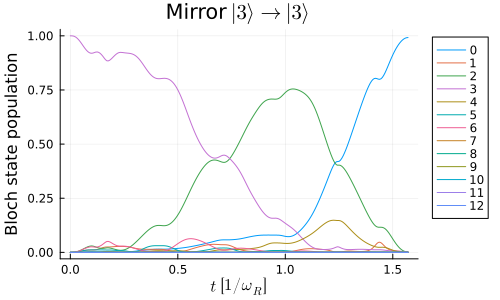

In [208]:
p = Plots.plot(times, pops0[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="Bloch state population"
)
Plots.title!(p, L"Mirror $|%$(bloch_subspace[1])\rangle \rightarrow |%$(bloch_subspace[1])\rangle$")

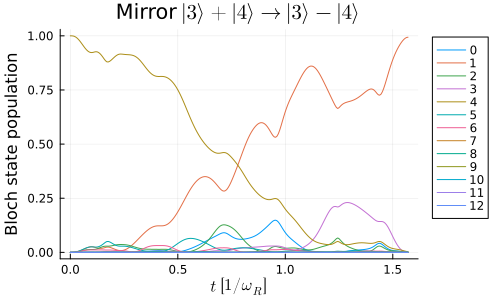

In [209]:
p = Plots.plot(times, pops1[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="Bloch state population"
)
Plots.title!(p, L"Mirror $|%$(bloch_subspace[1])\rangle+|%$(bloch_subspace[2])\rangle \rightarrow |%$(bloch_subspace[1])\rangle-|%$(bloch_subspace[2])\rangle$")

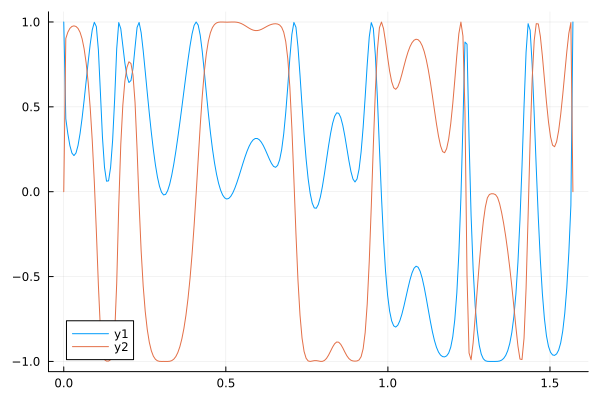

In [210]:
Plots.plot(times, Z.a')

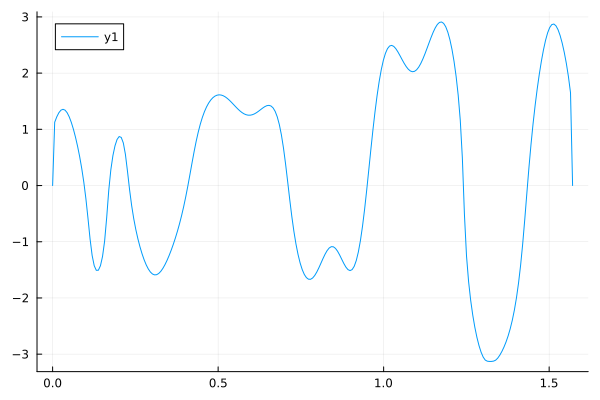

In [211]:
Plots.plot(times, Z.phi')

In [212]:
Plots.plot(times, Z.dphi')

LoadError: type NamedTuple has no field dphi

In [213]:
Plots.plot(times, Z.ddphi')

LoadError: type NamedTuple has no field ddphi

In [214]:
p = Plots.plot(times, Z.phi', linecolor=:blue, label=L"\varphi(t)", size=(500, 300))
# Plots.plot!(p, times, phase_bound.(times), linecolor=:grey, label="bound")
# Plots.plot!(p, times, -phase_bound.(times), linecolor=:grey, label="bound")
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="shaking amplitude"
)
Plots.title!(p, L"Mirror $|7\rangle$")

In [ ]:
pops[:,end]

In [ ]:
Plots.plot(times, acos.(Z.a[1,:]))

In [ ]:
Z_guess = Z
Z_save = deepcopy(Z)

In [ ]:
Z_guess = trajectory_shrink_extend(Z, 1001)

In [215]:
import JLD2

In [216]:
JLD2.save("interferometer/hold_34_0.25wr.jld2", Z)

In [ ]:
function fourier_time_freq(data_time, times, freqs)
    dts = times[2:end] - times[1:end-1]
    push!(dts, dts[end])
    ft_mat = exp.(2im*pi*freqs*times')
    data_freq = (dts' .* ft_mat) * data_time / sqrt.(2pi)
    return data_freq
end

In [ ]:
freqs = collect(0:0.1:60)
phi_ft = fourier_time_freq(Z.a[2,:], times, freqs/(2pi));
#phi_ft = fourier_time_freq(phi, times, freqs/(2pi));

In [ ]:
Plots.plot(freqs, abs2.(phi_ft))#, ylims=(0.0, 0.01))

## convergence plot

In [163]:
L = zeros(201)
grad = zeros(201)
open("convergence2.txt") do f
    global L, grad
    while !eof(f)
        s = strip(readline(f))
        pcs = split(s, " ")
        pcs = filter(x -> x != "", pcs)
        try
            i = parse(Int, pcs[1])
        catch
            println("catch")
            continue
        end
        L[i+1] = parse(Float64, pcs[2])
        grad[i+1] = parse(Float64, pcs[6])
        i += 1
    end
end

catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch


In [164]:
L = hcat(L, zeros(201))
grad = hcat(grad, zeros(201))
open("convergence1.txt") do f
    global L, grad
    while !eof(f)
        s = strip(readline(f))
        pcs = split(s, " ")
        pcs = filter(x -> x != "", pcs)
        try
            i = parse(Int, pcs[1])
        catch
            println("catch")
            continue
        end
        L[i+1,2] = parse(Float64, pcs[2])
        grad[i+1,2] = parse(Float64, pcs[6])
        i += 1
    end
end

catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch
catch


In [165]:
L

201×2 Matrix{Float64}:
 126.28       126.28
 109.415      116.074
 108.783      101.327
 122.668      100.826
 122.594      100.525
 120.363      100.635
 119.947      100.51
 122.265      100.42
 123.537      100.334
 122.958      100.258
   ⋮          
   0.101583   100.0
   0.101547   100.0
   0.094748   100.0
   0.0906403  100.0
   0.11058    100.0
   0.0931546  100.0
   0.0922879  100.0
   0.103963   100.0
   0.101276   100.0

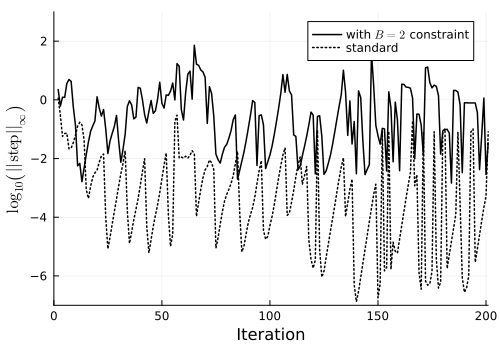

In [173]:
p = Plots.plot(
    log10.(grad),
    size=(500,350),
    label=[L"with $B=2$ constraint" "standard"], 
    legend=:topright,
    xlabel="Iteration",
    ylabel=L"\log_{10}\left(||\!\mathrm{step}\,|\!|_\infty\right)",
    ylim=(-7, 3),
    xlim=(0, 201),
    c=:black,
    linestyle=[:solid :dot],
    linewidth=1.5
    )

In [174]:
Plots.savefig(p, "patent_figs/step_size.pdf")

"/local/lmseifert/Infleqtion/research-superstaq/research_superstaq/theory/shaken_lattice/Max_QC/patent_figs/step_size.pdf"

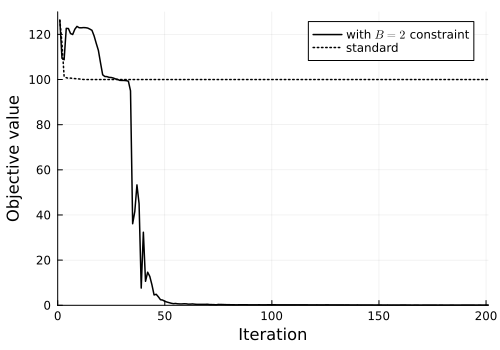

In [175]:
p = Plots.plot(
    L, 
    size=(500,350),
    label=[L"with $B=2$ constraint" "standard" ], 
    legend=:topright,
    xlabel="Iteration",
    ylabel="Objective value",
    xlim=(0, 201),
    ylim=(0., 130.),
    c=:black,
    linestyle=[:solid :dot],
    linewidth=1.5
    )

In [176]:
Plots.savefig(p, "patent_figs/convergence.pdf")

"/local/lmseifert/Infleqtion/research-superstaq/research_superstaq/theory/shaken_lattice/Max_QC/patent_figs/convergence.pdf"